<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 EM-DRATS (Environment for the Monitoring of Demographics, Retention, Affect, Tolerability, and Stratification)

requires:
Drop out questions_XXX.csv
wp2_post_session_4_XXX.csv
wp2_post_sessions_1-3_XXX.csv
wp2_pre_screen_XXX.csv
wp2_pre_session_1_XXX.csv
wp2_pre_sessions_2-4_XXX.csv
wp2_sms_day1,3,5_XXX.csv
wp2_sms_post_XXX.csv

creates:
wp2_assignments.csv
stratified & blinded sequence name per new participant ID
monitoring of wellbeing & tolerability
monitoring of demographic data, exclusion & retention rate

script 1: sign-up, demographic, retention (not for researcher use -- PI use only)
- run after running script 2 as it requires wp2_assignments

script 2: main blind stratification script (for researcher use)
- requires pre-screen CSV and creates list of blinded sequence names per new successful bookings (calendly_event_booked)
- below it is a stratification balance check, though it exposes number of strata per condition, so may unblind (not for researcher use -- PI use only)
- below the stratification balance check is the fixed seed (=42) through which our 5 control and 5 intervention sequences were renamed -- no need to ever run this again

script 3: main longitudinal wellbeing monitoring per condition/measure (not for researcher use -- PI use only)
- requires all 7 wellbeing CSVs
- plots per measure per condition with "worsening" part_ids outlined in summary tables below each measure plot
- used to see when clinicians should reach out to specific participants (touch base with researcher to link part_id to email)

script 4: main tolerability monitoring per condition (for any use)
- requires all post-session CSVs to make sure that session tolerability never exceeds our specified threshold
- future updates will incorporate FIBSER ratings? unsure

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load assignments
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

#####
# 0.1) Define manual‐exclusion list
# — either hard‐code IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274" # unable to make first session; excluding preliminarily
    # etc…
}

#####
# 1) Load & summarize pre‐screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre = df_pre.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 1.1) Drop your never‐attended exclusions before any summaries
df_pre = df_pre[~df_pre['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# 1a) Exclusion counts
excluded_counts = df_pre['excluded'].value_counts()
passed_count    = excluded_counts.get('FALSE', 0)
safety_excl     = excluded_counts.get('safety_screening', 0)
demo_excl       = excluded_counts.get('demographics', 0)

summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics'
    ],
    'Count': [
        passed_count,
        safety_excl,
        demo_excl
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# 1b) Demographics for Passed vs. Failed
df_pre['incl_dem_age'] = pd.to_numeric(df_pre['incl_dem_age'], errors='coerce')
df_pre['phq9_sum']     = pd.to_numeric(df_pre['phq9_sum'], errors='coerce')
df_pre['incl_dem_sex'] = df_pre['incl_dem_sex'].str.strip().str.lower()
valid_sex = ['male','female','other']
df_pre.loc[~df_pre['incl_dem_sex'].isin(valid_sex), 'incl_dem_sex'] = pd.NA

passed_df = df_pre[df_pre['excluded']=='FALSE']
failed_df = df_pre[df_pre['excluded']!='FALSE']

def summarize_group(group_df, title):
    print(f"\n=== {title} ===")
    mean_age = group_df['incl_dem_age'].mean()
    sd_age   = group_df['incl_dem_age'].std()
    print(f"Age (years)    Mean ± SD: {mean_age:.2f} ± {sd_age:.2f}")
    mean_phq = group_df['phq9_sum'].mean()
    sd_phq   = group_df['phq9_sum'].std()
    print(f"PHQ-9 Sum      Mean ± SD: {mean_phq:.2f} ± {sd_phq:.2f}")
    print("\nSex Breakdown:")
    sex_counts = (
        group_df['incl_dem_sex']
          .value_counts(dropna=True)
          .rename_axis('Sex')
          .reset_index(name='Count')
    )
    display(sex_counts)

summarize_group(passed_df, "Passed Participants")
summarize_group(failed_df, "Failed Participants")

#####
# 2) Who actually signed up (session1_pre) – overall, by condition, and retention
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str)
df_s1 = df_s1.merge(
    assign[['part_id','condition','sequence_name']],
    on='part_id', how='left'
)

# 2.1) Drop the same manual exclusions here
df_s1 = df_s1[~df_s1['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

df_s1['part_id_clean'] = df_s1['part_id'].str.strip()
passed_ids   = set(passed_df['part_id'])
real_signed  = set(df_s1['part_id_clean']) & passed_ids

# filter to only participants who passed and signed
df_s1_passed = df_s1[df_s1['part_id_clean'].isin(real_signed)]

signed_count = len(real_signed)
retention    = signed_count / passed_count if passed_count else 0

print(f"Of the {passed_count} who passed pre-screen, "
      f"{signed_count} actually signed up for Session 1.")
print(f"Overall retention: {retention:.1%}\n")

# breakdown by arm, counting unique participants
print("=== Sign-ups by Condition (only passed) ===")
sign_counts = (
    df_s1_passed
      .groupby('condition')['part_id_clean']
      .nunique()
      .rename('N_signups')
      .reset_index()
)
passed_by_cond = (
    passed_df
      .groupby('condition')['part_id']
      .nunique()
      .rename('N_passed')
      .reset_index()
)
ret_by_cond = pd.merge(sign_counts, passed_by_cond, on='condition')
ret_by_cond['Retention'] = ret_by_cond['N_signups'] / ret_by_cond['N_passed']
display(ret_by_cond)

#####
# 3) Summarize drop-out reasons – overall & by condition
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)

# unify and clean the ID column
id_cols = [c for c in df_drop.columns
           if c.lower() in ('part_id','responseid','externalreference','participantid','id')]
true_id = ( [c for c in id_cols if c=='part_id'] or [id_cols[0]] )[0]
df_drop = df_drop.rename(columns={true_id:'part_id'})
df_drop = df_drop.loc[:,~df_drop.columns.duplicated()]
df_drop['part_id'] = df_drop['part_id'].str.strip()

def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.strip()
    if t in (
      "I found the strobe experiences uncomfortable",
      "I believe I experienced some negative side effects from the strobe sessions"):
        return 'tolerability'
    if t == "I found coming to the appointment(s) too difficult":
        return 'scheduling'
    if t.startswith("I did not enjoy the study for other reasons"):
        return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)
df_drop = df_drop.merge(assign[['part_id','condition']], on='part_id', how='left')
drop_unique = df_drop[['part_id','condition','reason_cat']].drop_duplicates('part_id')

# overall drop-out
n_dropped    = drop_unique['part_id'].nunique()
drop_counts  = drop_unique['reason_cat'].value_counts().reindex(
                   ['tolerability','scheduling','other'], fill_value=0)
drop_summary = pd.DataFrame({
    'Reason': ['Side-effects / tolerability','Scheduling issues','Other'],
    'Count':  drop_counts.values
})
print(f"=== Drop-out Reasons (Overall: {n_dropped} of {signed_count} dropped) ===")
display(drop_summary)

# drop-out by arm
print("\n=== Drop-out by Condition ===")
drop_by_cond = (
    drop_unique
      .groupby(['condition','reason_cat'])['part_id']
      .nunique()
      .unstack(fill_value=0)
      .reindex(
         index=['control','intervention'],
         columns=['tolerability','scheduling','other'],
         fill_value=0
      )
)
dropped_per_arm = drop_unique.groupby('condition')['part_id'].nunique().rename('Dropped')
sign_per_arm    = ret_by_cond.set_index('condition')['N_signups']
drop_by_cond['Dropped']   = dropped_per_arm
drop_by_cond['Retention'] = 1 - (drop_by_cond['Dropped'] / sign_per_arm)
display(drop_by_cond)

#####
# 4) Narrative summary
#####
def get_retention_stats(df, condition):
    cond_df = df[df['condition']==condition]
    if cond_df.empty:
        return (0,0,0)
    return (
        cond_df['N_signups'].iat[0],
        cond_df['N_passed'].iat[0],
        cond_df['Retention'].iat[0]
    )

int_signups, int_passed, int_ret = get_retention_stats(ret_by_cond, 'intervention')
ctrl_signups, ctrl_passed, ctrl_ret = get_retention_stats(ret_by_cond, 'control')

int_dropped = dropped_per_arm.get('intervention', 0)
int_signed  = sign_per_arm.get('intervention', 1)
ctrl_dropped= dropped_per_arm.get('control', 0)
ctrl_signed = sign_per_arm.get('control', 1)

print(f"""
Summary:
- {passed_count} passed the pre-screen.
- {signed_count} of those ({retention:.1%}) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: {int_signups}/{int_passed} ({int_ret:.1%})
    • Control:      {ctrl_signups}/{ctrl_passed} ({ctrl_ret:.1%})
- Overall drop-out: {n_dropped} of {signed_count} dropped (retention {1-(n_dropped/signed_count):.1%})
- Drop-out by arm:
    • Intervention: {int_dropped}/{int_signed} dropped ({1-(int_dropped/int_signed):.1%} retention)
    • Control:      {ctrl_dropped}/{ctrl_signed} dropped ({1-(ctrl_dropped/ctrl_signed):.1%} retention)
""")

=== Pre-screen Exclusion Summary ===


,Category,Count
0,# Passed pre-screen,6
1,# Excluded for safety,0
2,# Excluded for demographics,2



=== Passed Participants ===
Age (years)    Mean ± SD: 27.00 ± 1.10
PHQ-9 Sum      Mean ± SD: 26.00 ± 2.45

Sex Breakdown:


,Sex,Count
0,male,3
1,other,2
2,female,1



=== Failed Participants ===
Age (years)    Mean ± SD: 26.00 ± 0.00
PHQ-9 Sum      Mean ± SD: 22.00 ± 7.07

Sex Breakdown:


,Sex,Count
0,other,2


Of the 6 who passed pre-screen, 1 actually signed up for Session 1.
Overall retention: 16.7%

=== Sign-ups by Condition (only passed) ===


,condition,N_signups,N_passed,Retention
0,intervention,1,2,0.5


=== Drop-out Reasons (Overall: 6 of 1 dropped) ===


,Reason,Count
0,Side-effects / tolerability,3
1,Scheduling issues,2
2,Other,0



=== Drop-out by Condition ===


reason_cat,tolerability,scheduling,other,Dropped,Retention
condition,,,,,
control,1,1,0,2,NaN
intervention,1,1,0,2,-1.0



Summary:
- 6 passed the pre-screen.
- 1 of those (16.7%) signed up for Session 1.
- Sign-ups by arm:
    • Intervention: 1/2 (50.0%)
    • Control:      0/0 (0.0%)
- Overall drop-out: 6 of 1 dropped (retention -500.0%)
- Drop-out by arm:
    • Intervention: 2/1 dropped (-100.0% retention)
    • Control:      2/1 dropped (-100.0% retention)



# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations -- MAKE SURE TO SAVE AND DATE THE LAST ITERATION!!! (then, when reuploading, remove data marker [just "wp2_assignments"])




In [2]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 0) Define manual‐exclusion list
#####
# — either hard-code the IDs here:
MANUAL_EXCLUDE_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    # 11198 reserved for manual scheduling
    # 11139 reserved for manual scheduling
    "11382", # requested to withdraw and have data deleted before Session 1
    "11290", # missed Session 1 and never rescheduled
    "11302" # missed Session 1, we'll see if they reschedule
}

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded code pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)

# strip whitespace from column names & IDs
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].astype(str).str.strip()

# (a) exclude anyone marked excluded==FALSE
df = df[df['excluded'].astype(str).str.strip().str.lower() == 'false'].copy()

# (b) only those who booked or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked']
      .fillna('')
      .str.strip()
      .str.lower()
)
df = df[df['calendly_event_booked_clean'].isin(['true','none_available'])].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# 3.1) remove any participants you want to exclude entirely
df = df[~df['part_id'].isin(MANUAL_EXCLUDE_IDS)].copy()

# (c) PHQ-9 strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin).fillna('') + '_' +
    df['incl_dem_med'].astype(str).str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")].copy()

# keep original order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments (if any)
#####
# 4) Load existing assignments (if any)
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns     = existing.columns.str.strip()
    existing['part_id']  = existing['part_id'].str.strip()
    # <-- prune cancelled IDs out of your saved assignments
    existing = existing[~existing['part_id'].isin(MANUAL_EXCLUDE_IDS)]
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

assigned = existing[['part_id','stratum','condition']].copy()
base_idx = len(assigned)

#####
# 5) Merge in to see who’s new
#####
merged = df[['part_id','stratum','_order']].merge(
    assigned, on=['part_id','stratum'], how='left'
).reset_index(drop=True)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Block‐randomize any new participants
#####
def assign_block(idx: int, stratum: str) -> str:
    seed_int = None if SEED is None else int(
        hashlib.sha256(f"{SEED}-{stratum}-{idx//BLOCK_SIZE}".encode()).hexdigest(), 16
    )
    rng = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: r['condition']
              if pd.notna(r['condition'])
              else assign_block(base_idx + r.name, r['stratum']),
    axis=1
)

#####
# 7) Assign sequence codes globally
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 8) Save & print debug
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

print("Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

Newly assigned participants:
   part_id sequence_name
30   11220    WP2-032756


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [ ]:
#####
# 9) Blind stratification check
#####
# 'merged' is the DataFrame you built in Script B, with columns
# ['part_id','stratum','condition','sequence_name','is_new',…]
new_out   = merged[merged['is_new']]
new_count = len(new_out)

if new_count >= BLOCK_SIZE:
    if new_count == BLOCK_SIZE:
        prompt = "At least one full new block has been added. Proceed with stratification check? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Checking stratification now may unblind. "
            "Continue anyway? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y','yes'):
        summary = (
            new_out
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check (new block):")
        print(summary)
        print("Assignment counts by arm:")
        print(full['condition'].value_counts(), "\n")
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 1 new participants added (< 4); skipping stratification check.


Total Stratification Checker -- Condition & Strata

In [3]:
import pandas as pd

# Load the assignments CSV
wp2_assignments = pd.read_csv('wp2_assignments.csv')

# 1) Count per condition
condition_counts = wp2_assignments['condition'].value_counts().sort_index()
print("Assignment counts by condition:")
print(condition_counts)

# 2) Count per stratum
stratum_counts = wp2_assignments['stratum'].value_counts().sort_index()
print("\nAssignment counts by stratum:")
print(stratum_counts)

Assignment counts by condition:
condition
control         16
intervention    15
Name: count, dtype: int64

Assignment counts by stratum:
stratum
high_no      3
high_yes     2
low_no      12
low_yes     14
Name: count, dtype: int64


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script

This monitor will unblind researchers to part_id:condition allocation; please run the one below for a condition-blind part_id monitoring of wellbeing.






Loaded 'pre_session_1' from wp2_pre_session_1_June 23, 2025_07.39.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_June 23, 2025_07.56.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_June 23, 2025_07.39.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_June 23, 2025_07.40.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv

── phq9_sum  |  Condition: control ──


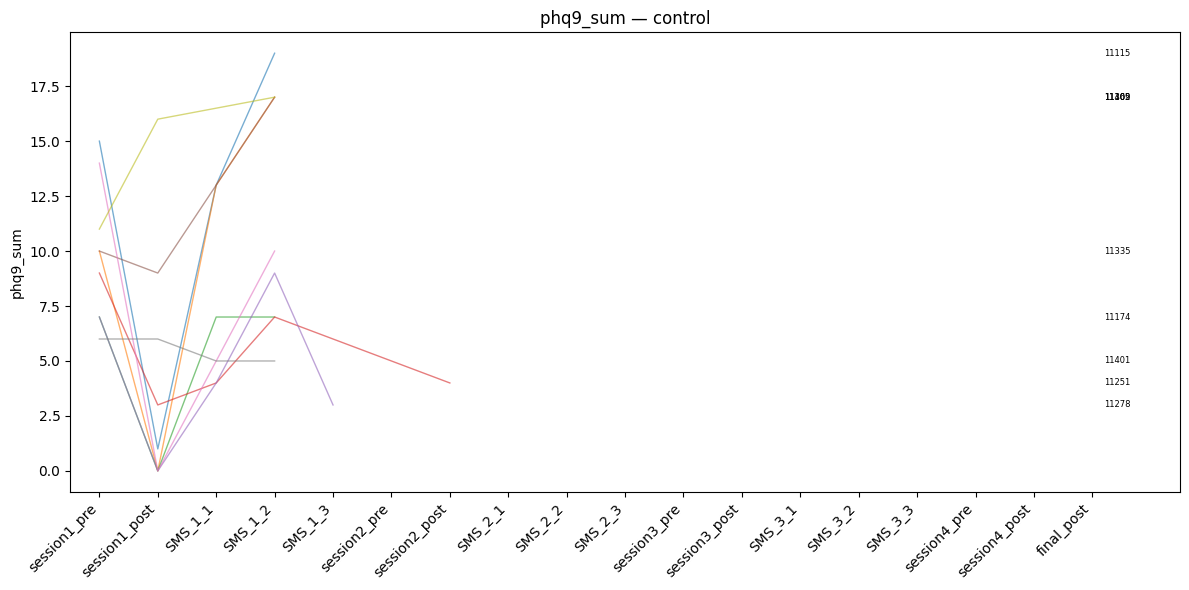

Worsened trajectories:


,part_id,timepoint,phq9_sum
0,11115,session1_pre,15.0
1,11115,session1_post,1.0
2,11115,SMS_1_1,13.0
3,11115,SMS_1_2,19.0
4,11162,session1_pre,10.0
5,11162,session1_post,0.0
6,11162,SMS_1_1,13.0
7,11162,SMS_1_2,17.0
8,11309,session1_pre,10.0
9,11309,session1_post,9.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 5):


,part_id,timepoint,phq9_sum
0,11162,session1_pre,10.0
1,11162,session1_post,0.0
2,11162,SMS_1_1,13.0
3,11162,SMS_1_2,17.0
4,11309,session1_pre,10.0
5,11309,session1_post,9.0
6,11309,SMS_1_1,13.0
7,11309,SMS_1_2,17.0
8,11405,session1_pre,11.0
9,11405,session1_post,16.0



── phq9_sum  |  Condition: intervention ──


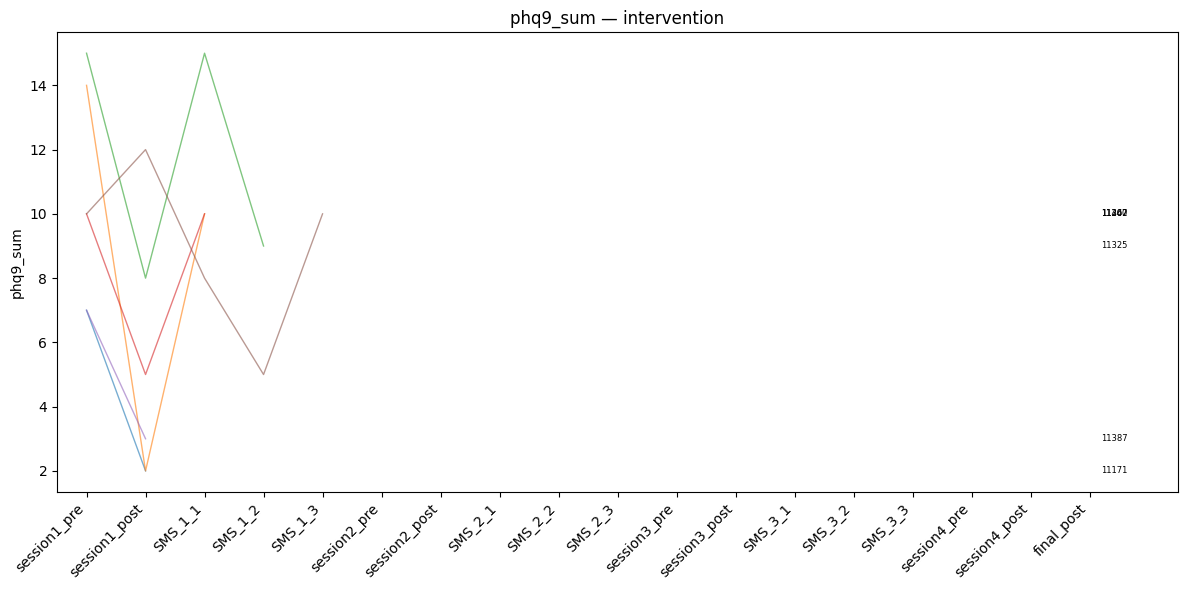

No worsening in this condition.
No participants worsened by at least the MCID of 5 for phq9_sum.

── spane_p  |  Condition: control ──


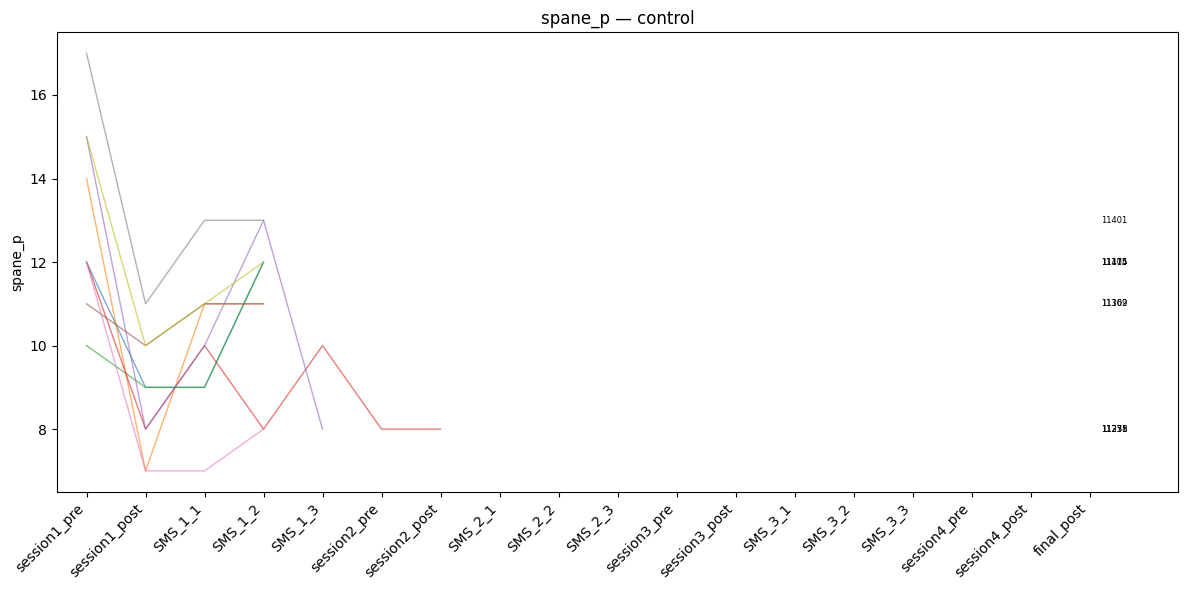

Worsened trajectories:


,part_id,timepoint,spane_p
0,11162,session1_pre,14.0
1,11162,session1_post,7.0
2,11162,SMS_1_1,11.0
3,11162,SMS_1_2,11.0
4,11251,session1_pre,12.0
5,11251,session1_post,8.0
6,11251,SMS_1_1,10.0
7,11251,SMS_1_2,8.0
8,11251,SMS_1_3,10.0
9,11251,session2_pre,8.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 2):


,part_id,timepoint,spane_p
0,11162,session1_pre,14.0
1,11162,session1_post,7.0
2,11162,SMS_1_1,11.0
3,11162,SMS_1_2,11.0
4,11251,session1_pre,12.0
5,11251,session1_post,8.0
6,11251,SMS_1_1,10.0
7,11251,SMS_1_2,8.0
8,11251,SMS_1_3,10.0
9,11251,session2_pre,8.0



── spane_p  |  Condition: intervention ──


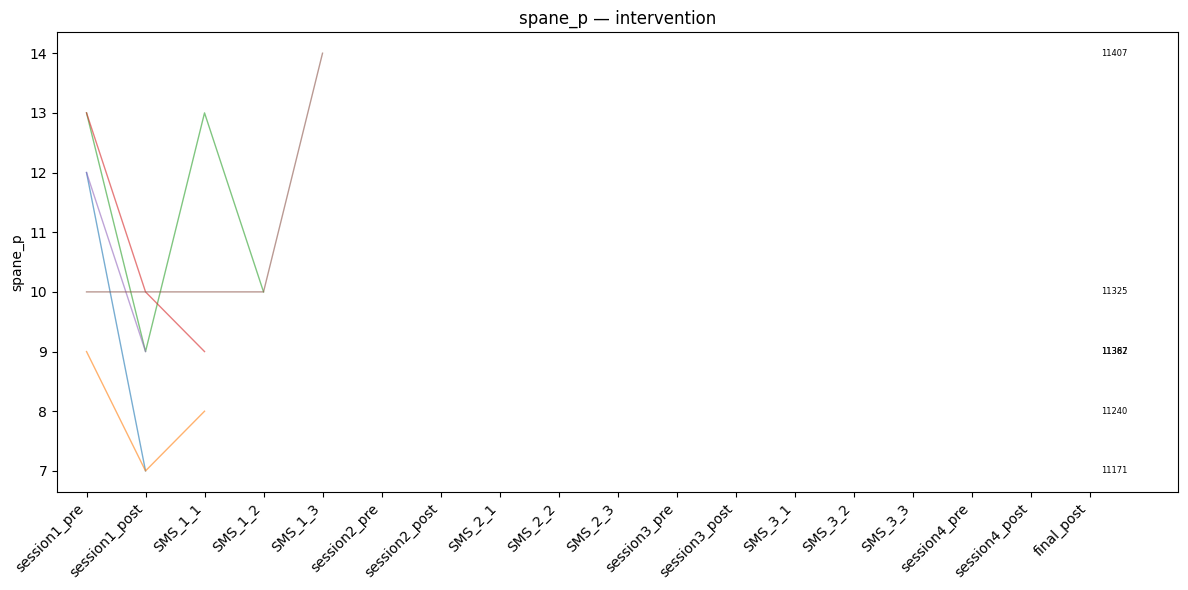

Worsened trajectories:


,part_id,timepoint,spane_p
0,11171,session1_pre,12.0
1,11171,session1_post,7.0
2,11240,session1_pre,9.0
3,11240,session1_post,7.0
4,11240,SMS_1_1,8.0
5,11325,session1_pre,13.0
6,11325,session1_post,9.0
7,11325,SMS_1_1,13.0
8,11325,SMS_1_2,10.0
9,11362,session1_pre,13.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 2):


,part_id,timepoint,spane_p
0,11171,session1_pre,12.0
1,11171,session1_post,7.0
2,11325,session1_pre,13.0
3,11325,session1_post,9.0
4,11325,SMS_1_1,13.0
5,11325,SMS_1_2,10.0
6,11362,session1_pre,13.0
7,11362,session1_post,10.0
8,11362,SMS_1_1,9.0
9,11387,session1_pre,12.0



── spane_n  |  Condition: control ──


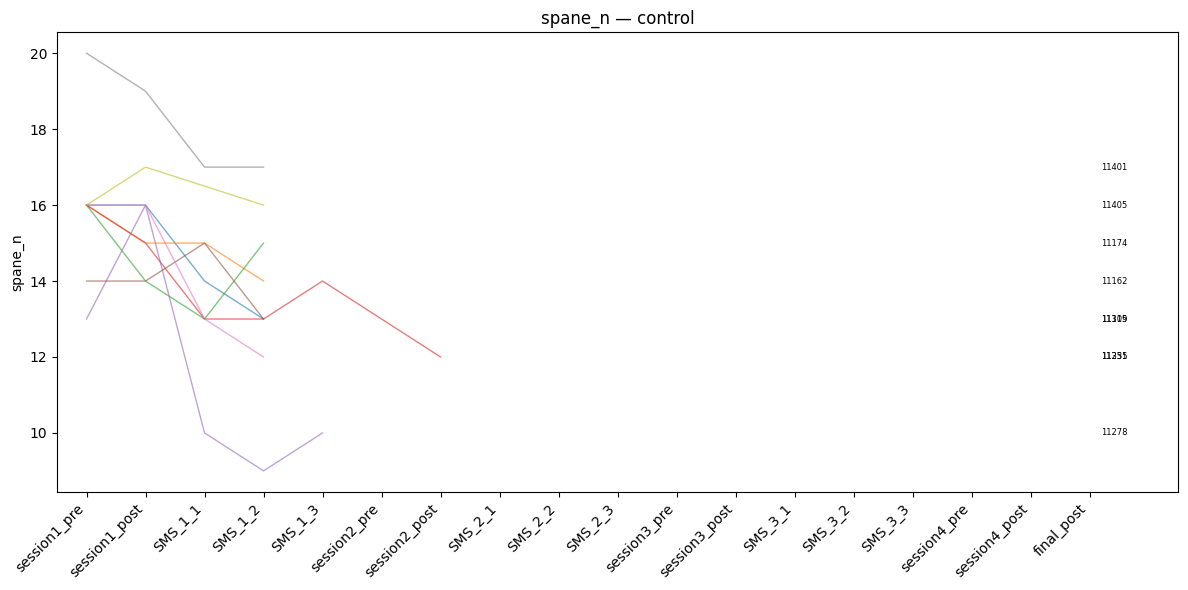

No worsening in this condition.
No participants worsened by at least the MCID of 2 for spane_n.

── spane_n  |  Condition: intervention ──


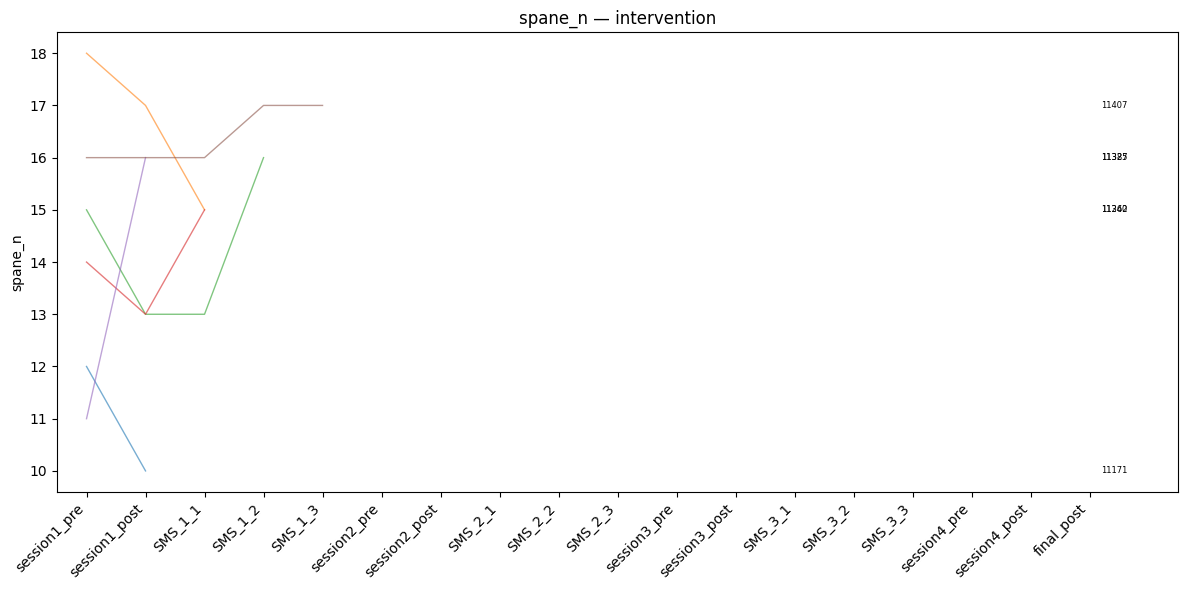

Worsened trajectories:


,part_id,timepoint,spane_n
0,11325,session1_pre,15.0
1,11325,session1_post,13.0
2,11325,SMS_1_1,13.0
3,11325,SMS_1_2,16.0
4,11362,session1_pre,14.0
5,11362,session1_post,13.0
6,11362,SMS_1_1,15.0
7,11387,session1_pre,11.0
8,11387,session1_post,16.0
9,11407,session1_pre,16.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 2):


,part_id,timepoint,spane_n
0,11387,session1_pre,11.0
1,11387,session1_post,16.0



── m3vas_mood  |  Condition: control ──


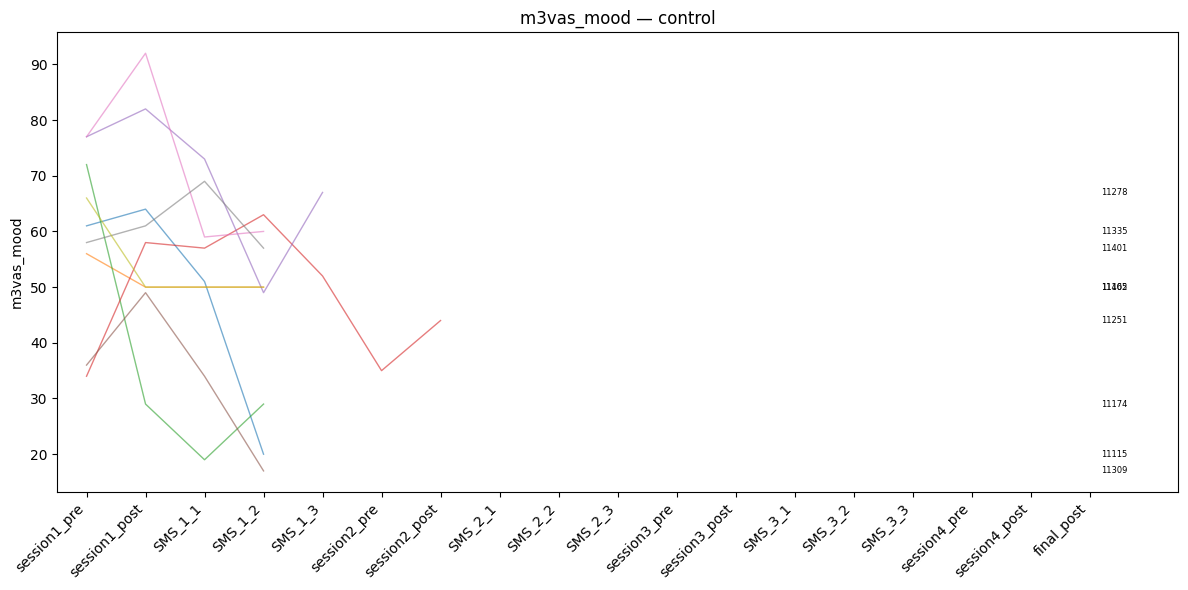

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11115,session1_pre,61.0
1,11115,session1_post,64.0
2,11115,SMS_1_1,51.0
3,11115,SMS_1_2,20.0
4,11162,session1_pre,56.0
5,11162,session1_post,50.0
6,11162,SMS_1_1,50.0
7,11162,SMS_1_2,50.0
8,11174,session1_pre,72.0
9,11174,session1_post,29.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_mood
0,11115,session1_pre,61.0
1,11115,session1_post,64.0
2,11115,SMS_1_1,51.0
3,11115,SMS_1_2,20.0
4,11174,session1_pre,72.0
5,11174,session1_post,29.0
6,11174,SMS_1_1,19.0
7,11174,SMS_1_2,29.0
8,11309,session1_pre,36.0
9,11309,session1_post,49.0



── m3vas_mood  |  Condition: intervention ──


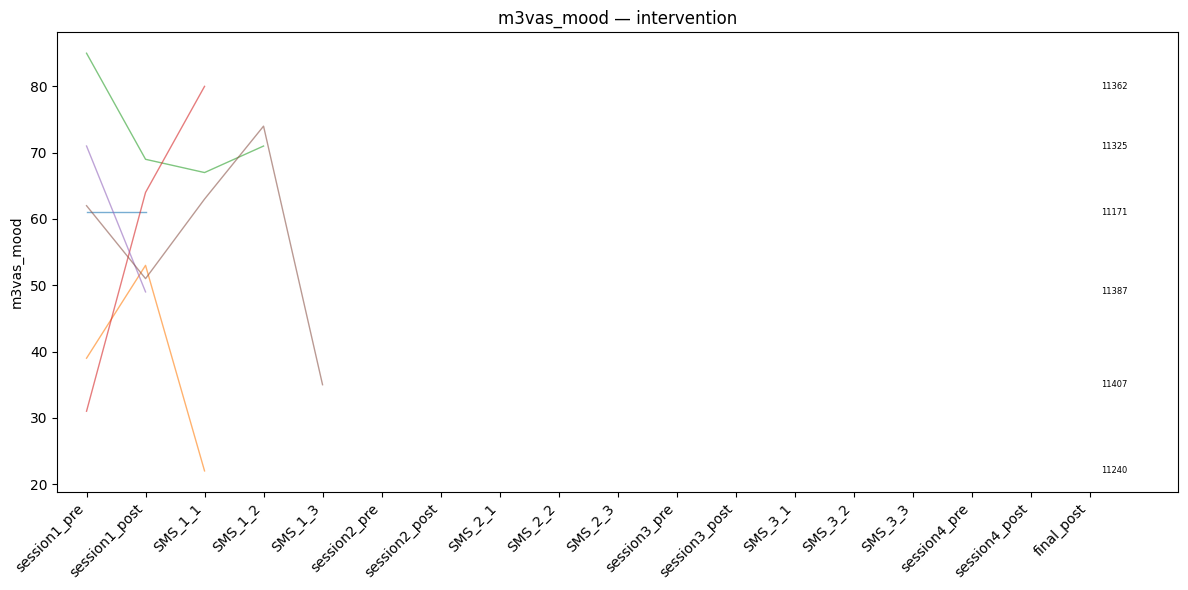

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11240,session1_pre,39.0
1,11240,session1_post,53.0
2,11240,SMS_1_1,22.0
3,11325,session1_pre,85.0
4,11325,session1_post,69.0
5,11325,SMS_1_1,67.0
6,11325,SMS_1_2,71.0
7,11387,session1_pre,71.0
8,11387,session1_post,49.0
9,11407,session1_pre,62.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_mood
0,11240,session1_pre,39.0
1,11240,session1_post,53.0
2,11240,SMS_1_1,22.0
3,11325,session1_pre,85.0
4,11325,session1_post,69.0
5,11325,SMS_1_1,67.0
6,11325,SMS_1_2,71.0
7,11387,session1_pre,71.0
8,11387,session1_post,49.0
9,11407,session1_pre,62.0



── m3vas_pleasure  |  Condition: control ──


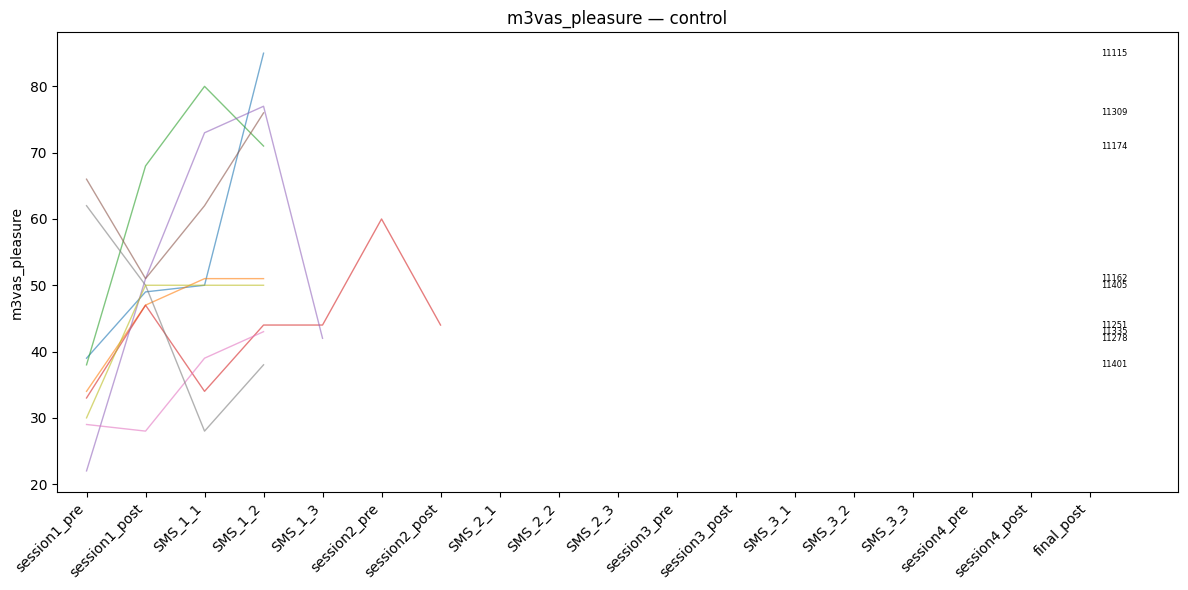

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11401,session1_pre,62.0
1,11401,session1_post,50.0
2,11401,SMS_1_1,28.0
3,11401,SMS_1_2,38.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_pleasure
0,11401,session1_pre,62.0
1,11401,session1_post,50.0
2,11401,SMS_1_1,28.0
3,11401,SMS_1_2,38.0



── m3vas_pleasure  |  Condition: intervention ──


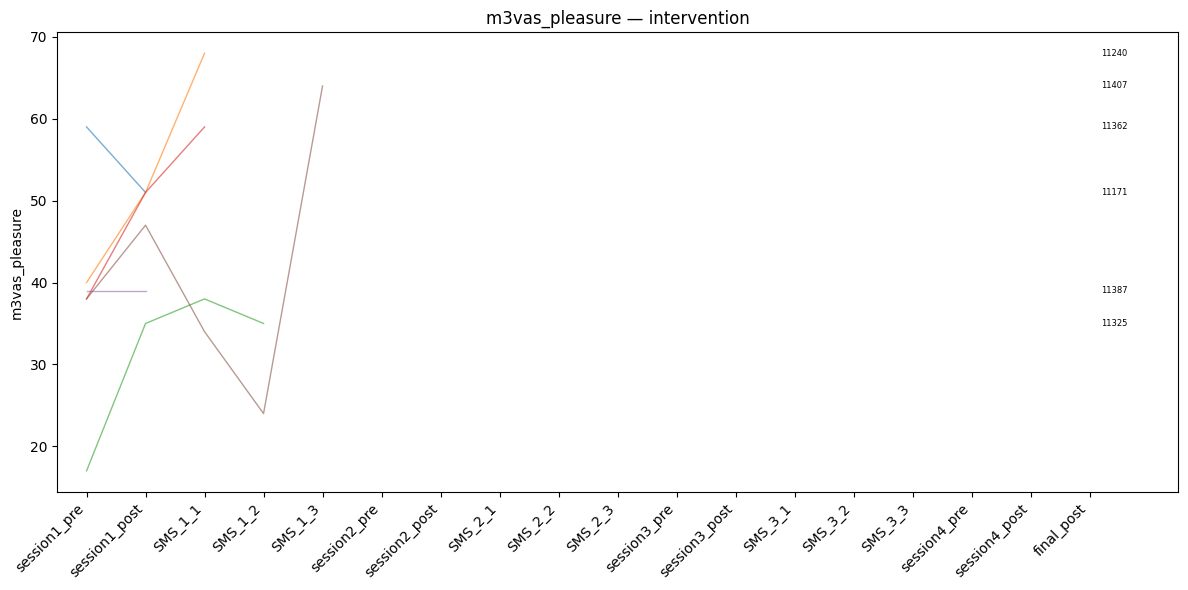

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11171,session1_pre,59.0
1,11171,session1_post,51.0


No participants worsened by at least the MCID of 12 for m3vas_pleasure.

── m3vas_suicidal  |  Condition: control ──


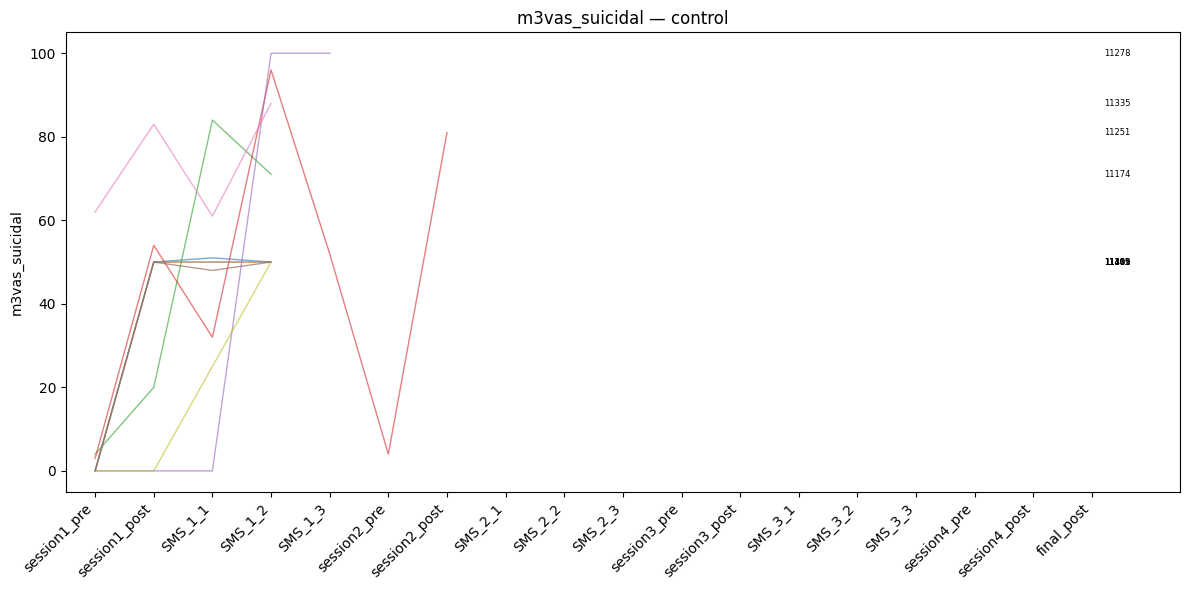

No worsening in this condition.
No participants worsened by at least the MCID of 12 for m3vas_suicidal.

── m3vas_suicidal  |  Condition: intervention ──


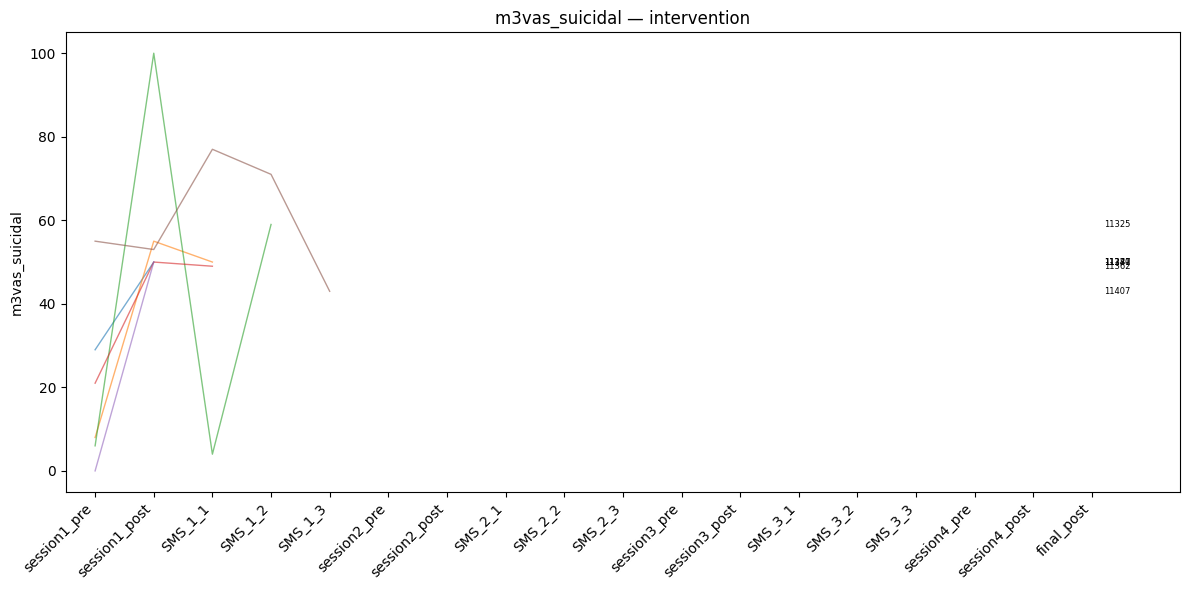

Worsened trajectories:


,part_id,timepoint,m3vas_suicidal
0,11407,session1_pre,55.0
1,11407,session1_post,53.0
2,11407,SMS_1_1,77.0
3,11407,SMS_1_2,71.0
4,11407,SMS_1_3,43.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_suicidal
0,11407,session1_pre,55.0
1,11407,session1_post,53.0
2,11407,SMS_1_1,77.0
3,11407,SMS_1_2,71.0
4,11407,SMS_1_3,43.0



── fisber_1  |  Condition: control ──


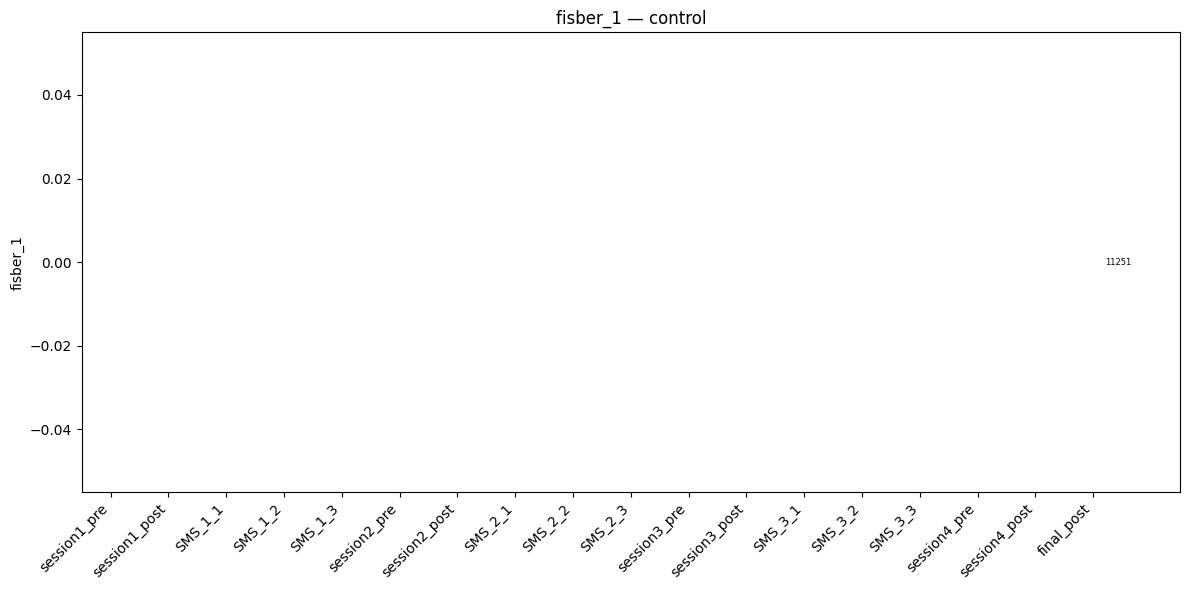

No worsening in this condition.

── fisber_1  |  Condition: intervention ──


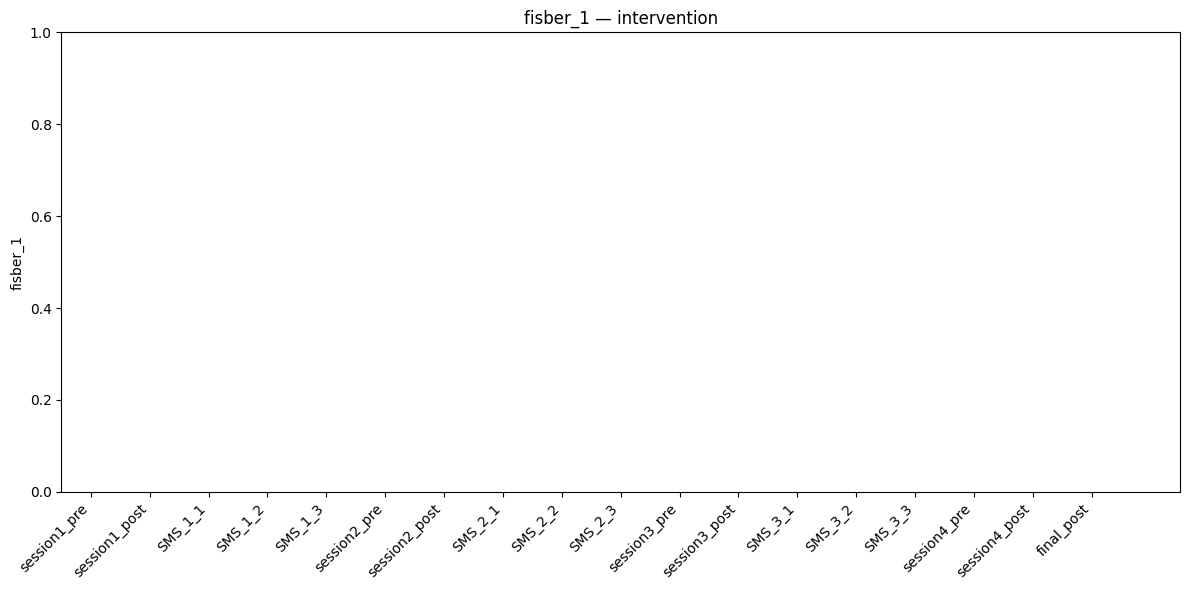

No worsening in this condition.

── fisber_2  |  Condition: control ──


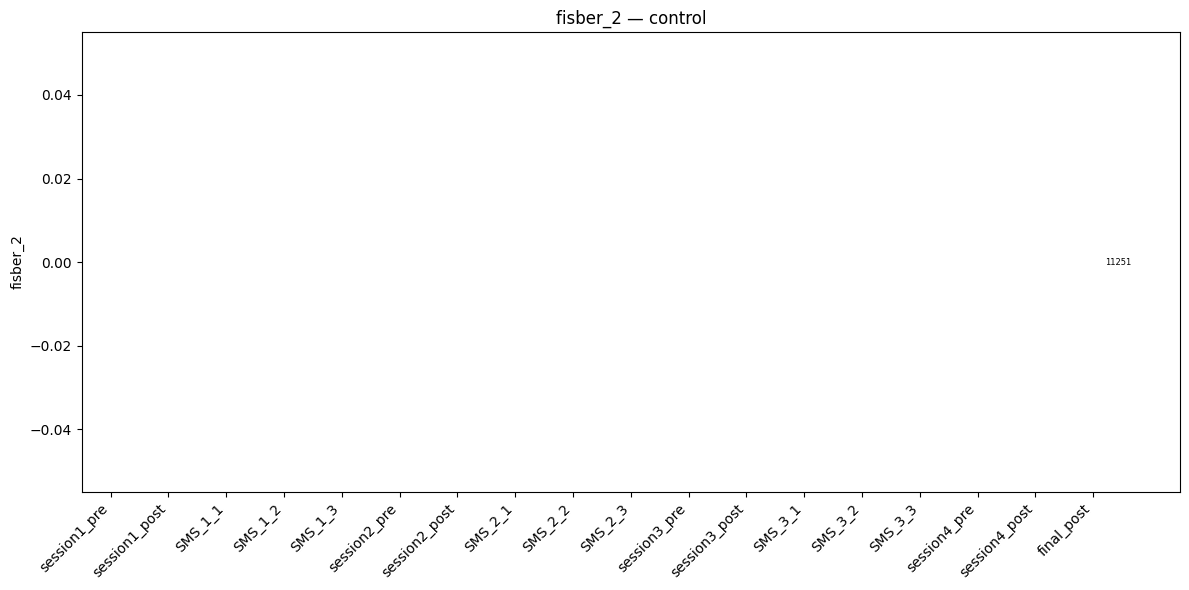

No worsening in this condition.

── fisber_2  |  Condition: intervention ──


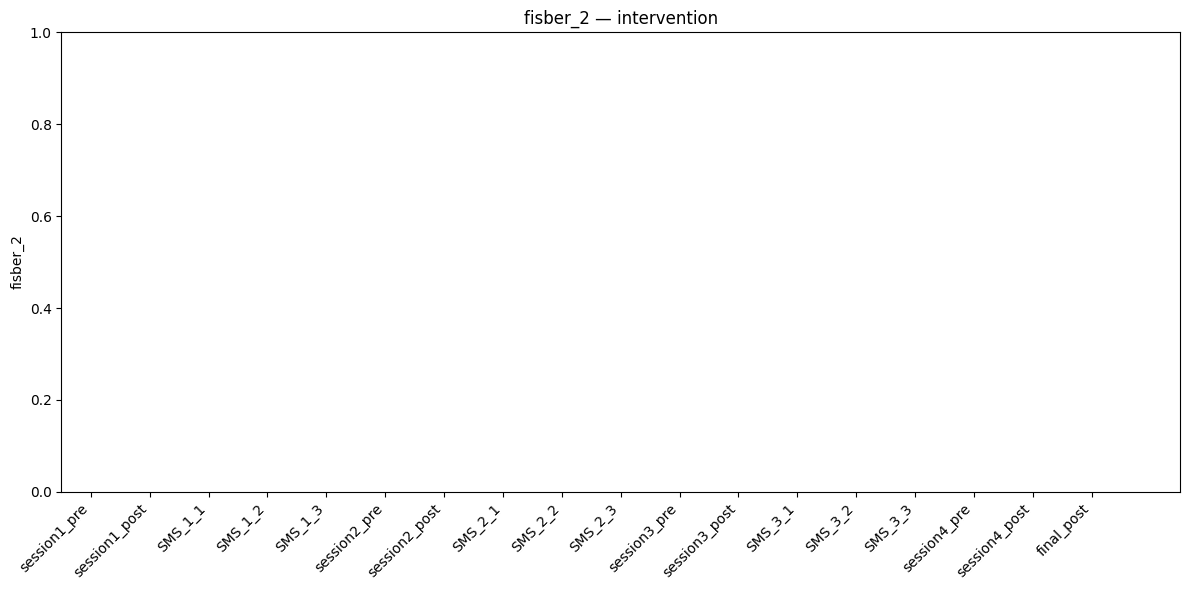

No worsening in this condition.

── fisber_3  |  Condition: control ──


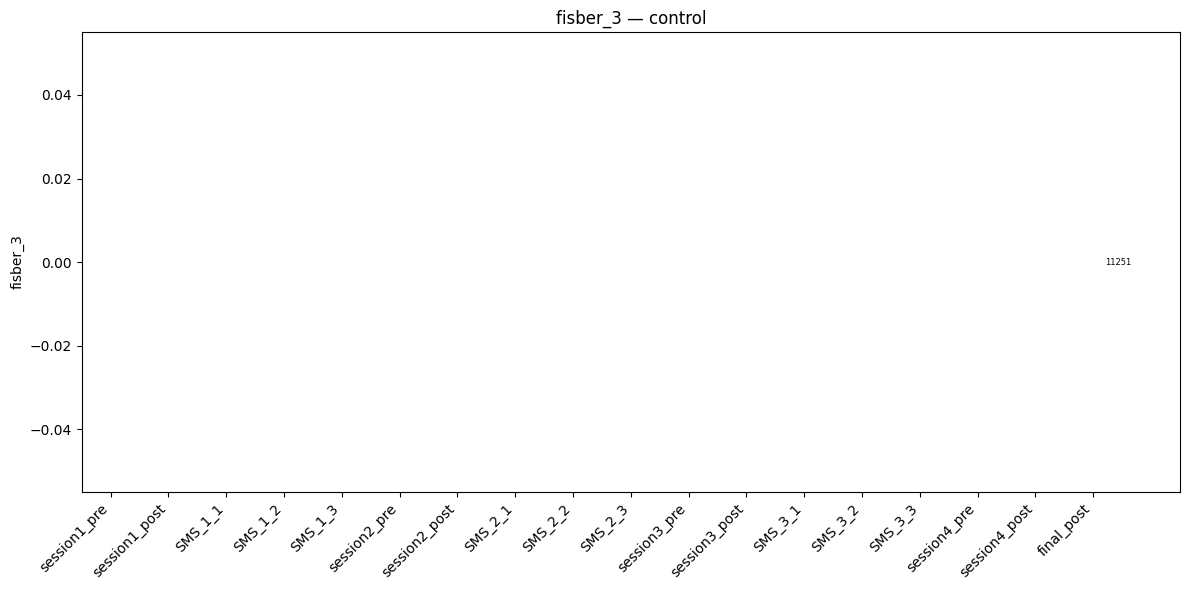

No worsening in this condition.

── fisber_3  |  Condition: intervention ──


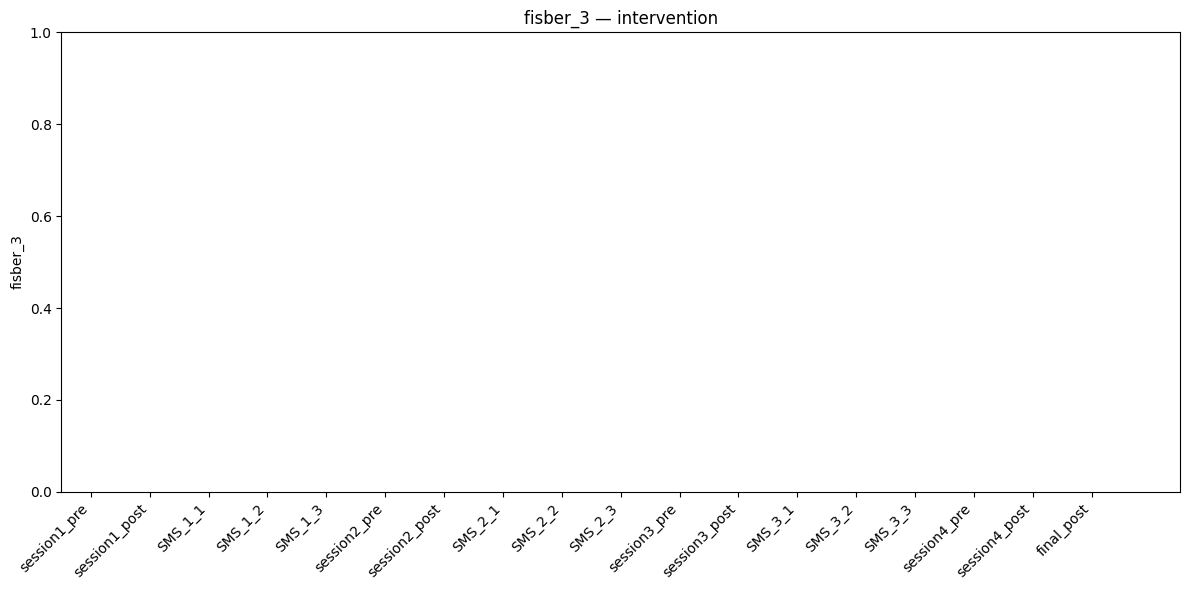

No worsening in this condition.

── bai_sum  |  Condition: control ──


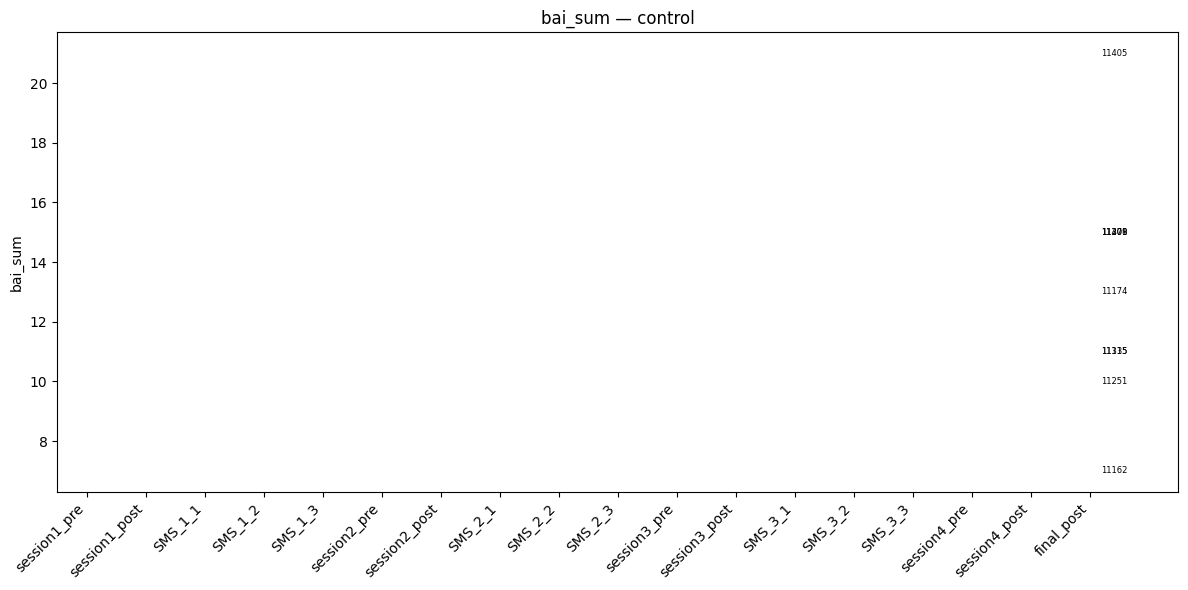

No worsening in this condition.

── bai_sum  |  Condition: intervention ──


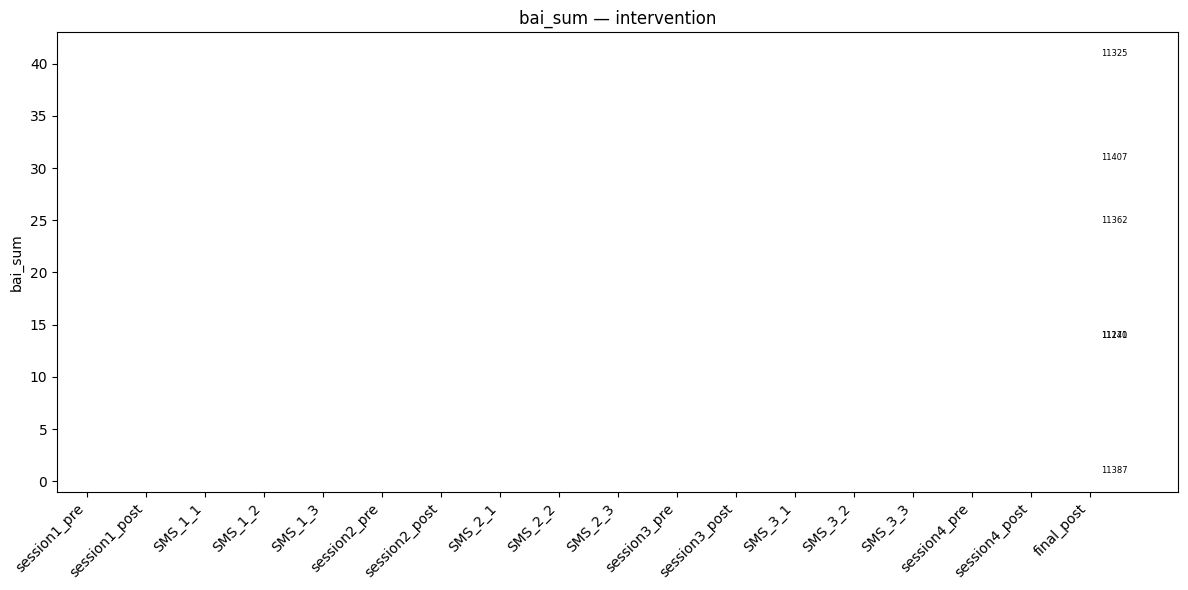

No worsening in this condition.

── bdi_sum  |  Condition: control ──


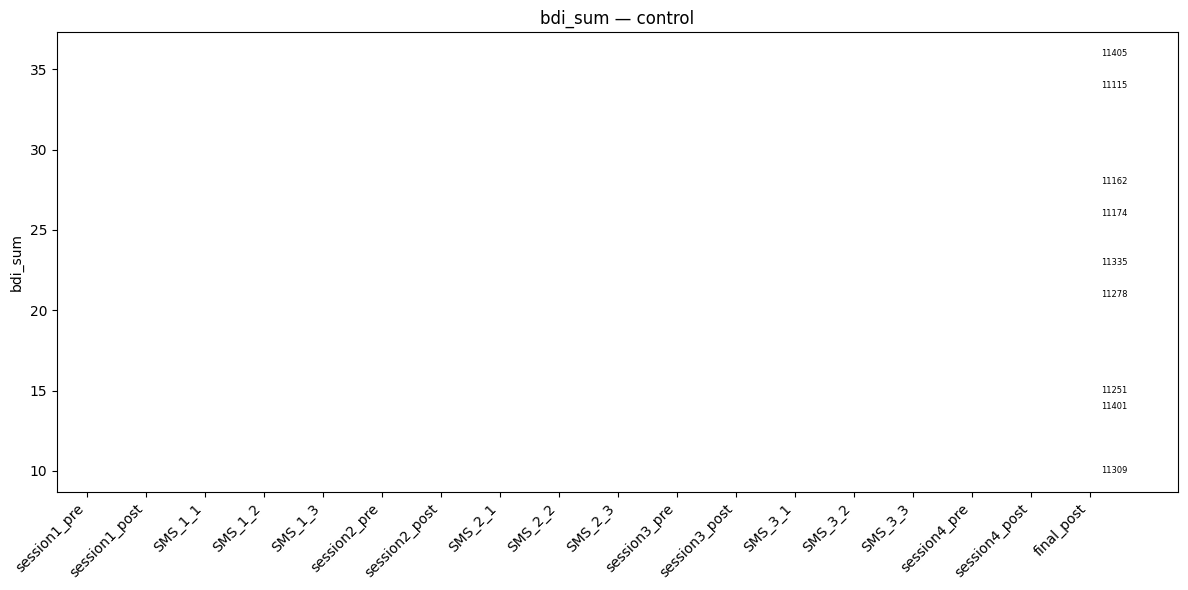

No worsening in this condition.

── bdi_sum  |  Condition: intervention ──


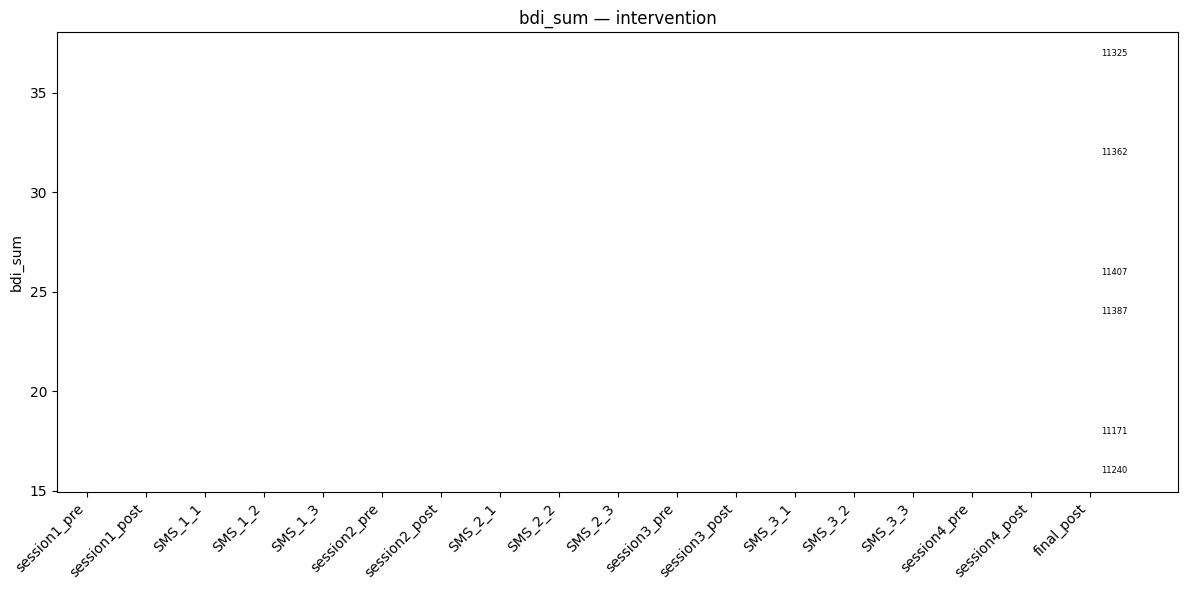

No worsening in this condition.

── MADRS_S_sum  |  Condition: control ──


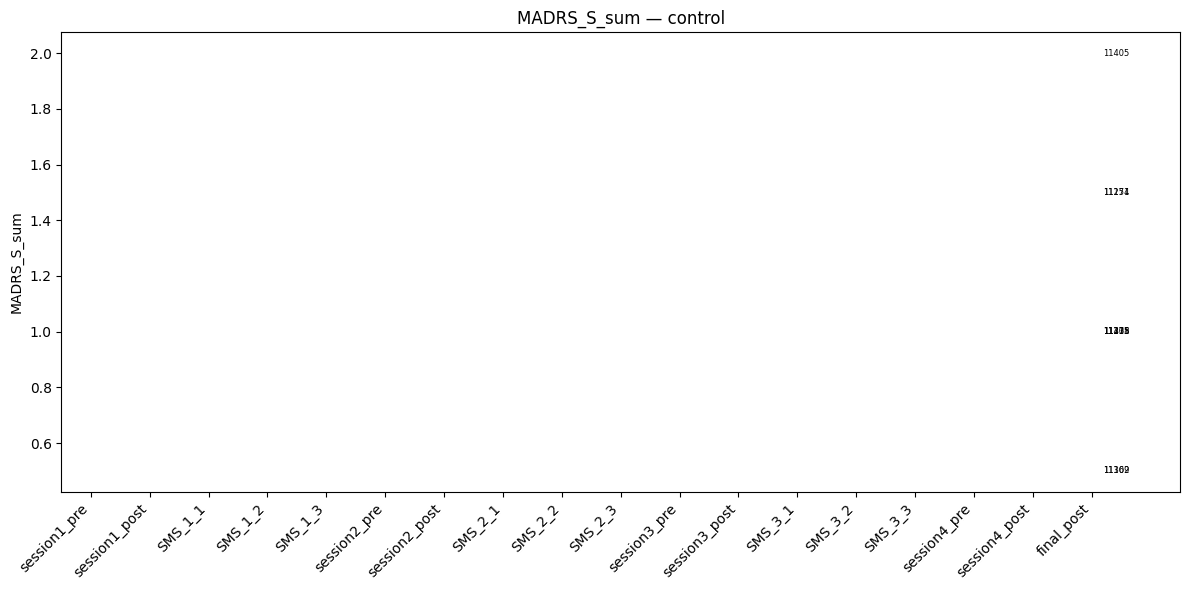

No worsening in this condition.

── MADRS_S_sum  |  Condition: intervention ──


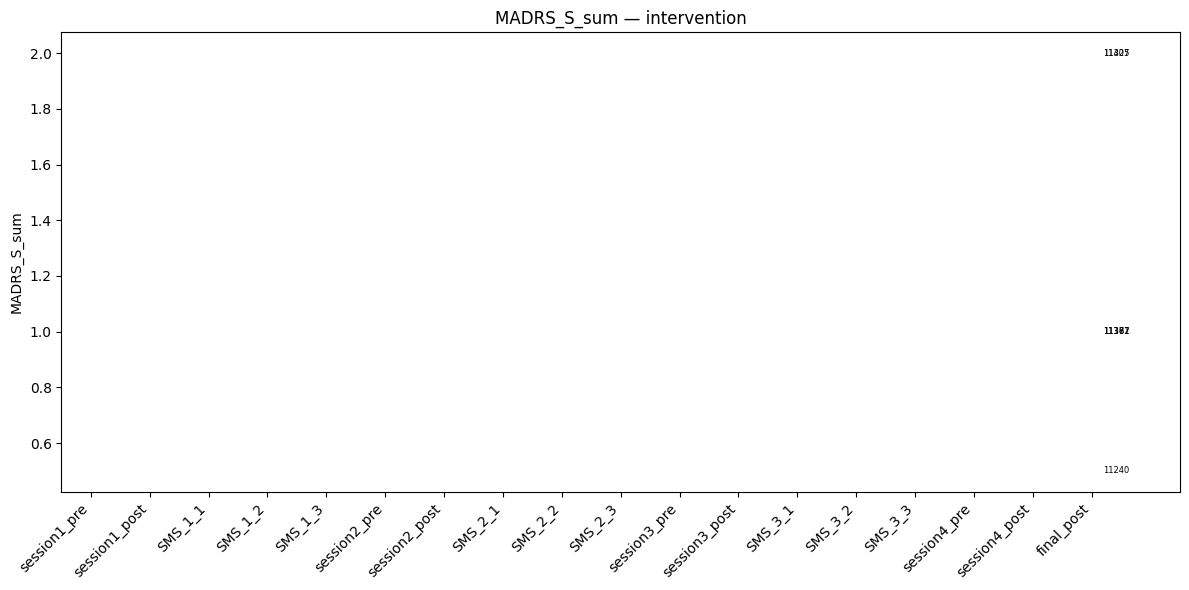

No worsening in this condition.


In [17]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum','spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
}
bad_if_lower = {'spane_p','m3vas_mood','m3vas_suicidal','m3vas_pleasure'}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS TO CENTER AT ZERO
#####
def standardize_m3vas(df):
    for var in ('mood', 'pleasure', 'suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)]
        if ch_cols:
            # change-based: stored as delta+50, so subtract 50
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') - 50
        elif raw_cols:
            # raw VAS: 0–100, subtract 50 to center
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce') - 50
    # invert pleasure so higher = more distress, then centered already
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = df['m3vas_pleasure'] * -1
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    for cond, dfc in df_long.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        # Plot trajectories
        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
            if s.empty: continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final+0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final+1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout(); plt.show()

        # Flag worsened trajectories
        worsened = []
        for pid, grp in dfc.groupby('part_id'):
            seq = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')[measure].astype(float)
            if len(seq) < 2: continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            print("Worsened trajectories:")
            display(
                dfc[dfc['part_id'].isin(worsened)][['part_id','timepoint', measure]]
                   .dropna(subset=[measure])
                   .sort_values(['part_id','timepoint'])
                   .reset_index(drop=True)
            )
        else:
            print("No worsening in this condition.")

        # Flag MCID breaches in worsening direction
        if measure in mcid_thresholds:
            th = mcid_thresholds[measure]
            breached = []
            for pid, grp in dfc.groupby('part_id'):
                seq = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')[measure].astype(float)
                if len(seq) < 2: continue
                change = seq.iloc[-1] - seq.iloc[0]
                if measure in bad_if_higher and change >= th:
                    breached.append(pid)
                elif measure in bad_if_lower and change <= -th:
                    breached.append(pid)
            if breached:
                print(f"Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ {th}):")
                display(
                    dfc[dfc['part_id'].isin(breached)][['part_id','timepoint', measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
                )
            else:
                print(f"No participants worsened by at least the MCID of {th} for {measure}.")

# RUN PLOTS FOR ALL MEASURES
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_and_flag_by_condition(m)

CONDITION-BLIND WELLBEING MONITORING

Loaded 'pre_session_1' from wp2_pre_session_1_June 23, 2025_07.39.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_June 23, 2025_07.56.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_June 23, 2025_07.39.csv
Skipping 'post_session_4': No file matching 'post_session_4' in /content
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_June 23, 2025_07.40.csv
Skipping 'sms_post': No file matching 'sms_post' in /content
Loaded 'wp2_assignments' from wp2_assignments.csv


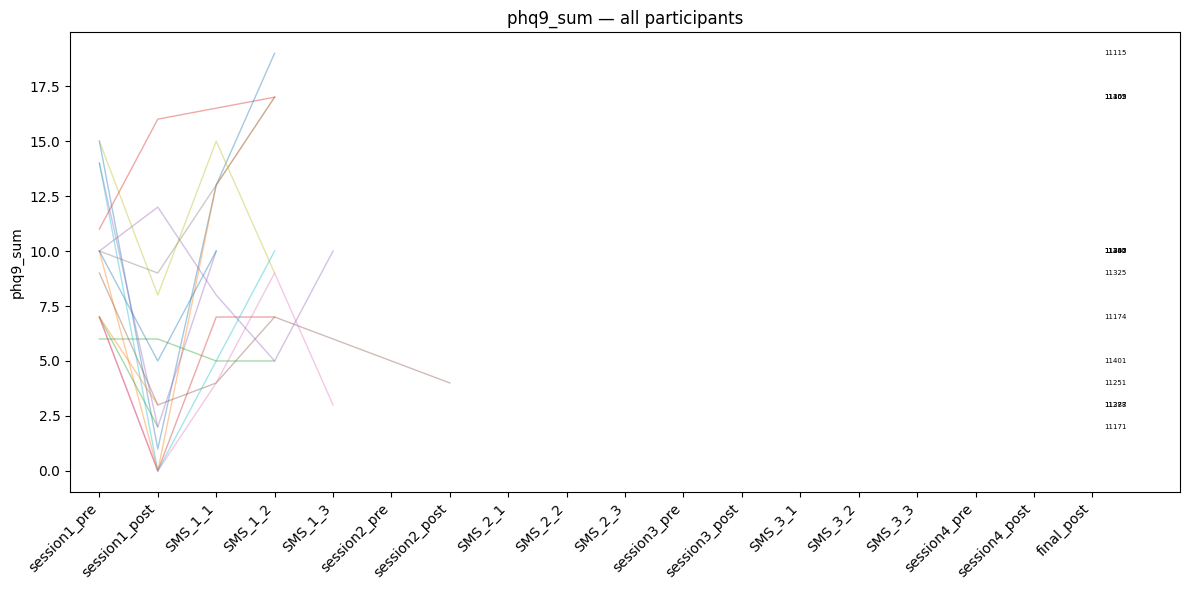

Worsened trajectories (blinded):


,part_id,timepoint,phq9_sum
0,11115,session1_pre,15.0
1,11115,session1_post,1.0
2,11115,SMS_1_1,13.0
3,11115,SMS_1_2,19.0
4,11162,session1_pre,10.0
5,11162,session1_post,0.0
6,11162,SMS_1_1,13.0
7,11162,SMS_1_2,17.0
8,11309,session1_pre,10.0
9,11309,session1_post,9.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 5):


,part_id,timepoint,phq9_sum
0,11162,session1_pre,10.0
1,11162,session1_post,0.0
2,11162,SMS_1_1,13.0
3,11162,SMS_1_2,17.0
4,11309,session1_pre,10.0
5,11309,session1_post,9.0
6,11309,SMS_1_1,13.0
7,11309,SMS_1_2,17.0
8,11405,session1_pre,11.0
9,11405,session1_post,16.0


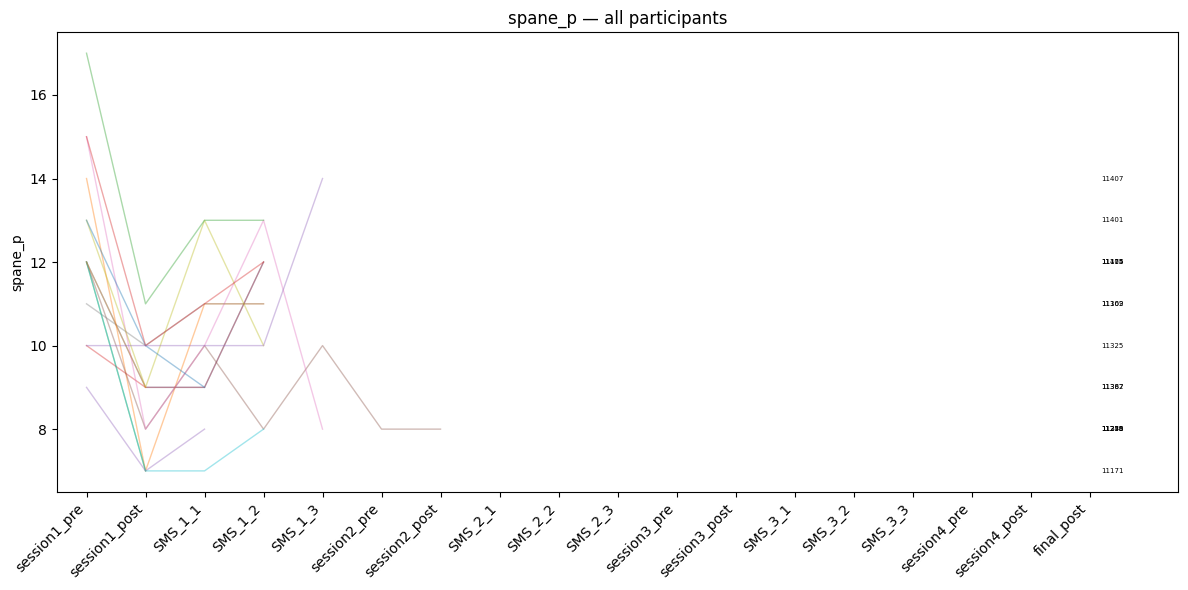

Worsened trajectories (blinded):


,part_id,timepoint,spane_p
0,11162,session1_pre,14.0
1,11162,session1_post,7.0
2,11162,SMS_1_1,11.0
3,11162,SMS_1_2,11.0
4,11171,session1_pre,12.0
5,11171,session1_post,7.0
6,11240,session1_pre,9.0
7,11240,session1_post,7.0
8,11240,SMS_1_1,8.0
9,11251,session1_pre,12.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 2):


,part_id,timepoint,spane_p
0,11162,session1_pre,14.0
1,11162,session1_post,7.0
2,11162,SMS_1_1,11.0
3,11162,SMS_1_2,11.0
4,11171,session1_pre,12.0
5,11171,session1_post,7.0
6,11251,session1_pre,12.0
7,11251,session1_post,8.0
8,11251,SMS_1_1,10.0
9,11251,SMS_1_2,8.0


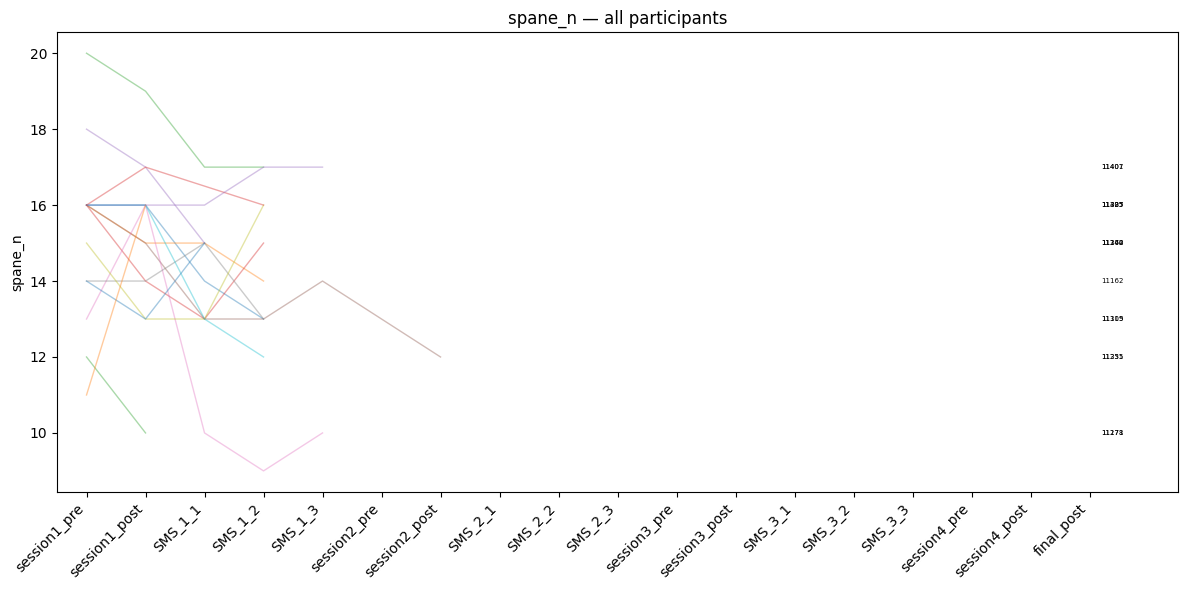

Worsened trajectories (blinded):


,part_id,timepoint,spane_n
0,11325,session1_pre,15.0
1,11325,session1_post,13.0
2,11325,SMS_1_1,13.0
3,11325,SMS_1_2,16.0
4,11362,session1_pre,14.0
5,11362,session1_post,13.0
6,11362,SMS_1_1,15.0
7,11387,session1_pre,11.0
8,11387,session1_post,16.0
9,11407,session1_pre,16.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 2):


,part_id,timepoint,spane_n
0,11387,session1_pre,11.0
1,11387,session1_post,16.0


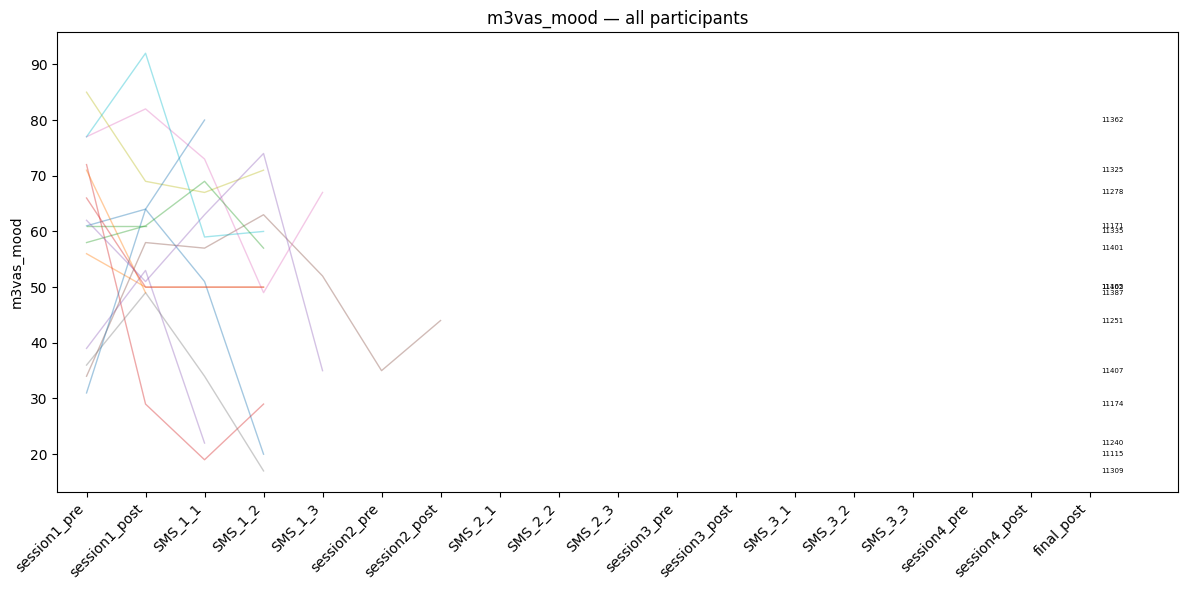

Worsened trajectories (blinded):


,part_id,timepoint,m3vas_mood
0,11115,session1_pre,61.0
1,11115,session1_post,64.0
2,11115,SMS_1_1,51.0
3,11115,SMS_1_2,20.0
4,11162,session1_pre,56.0
5,11162,session1_post,50.0
6,11162,SMS_1_1,50.0
7,11162,SMS_1_2,50.0
8,11174,session1_pre,72.0
9,11174,session1_post,29.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_mood
0,11115,session1_pre,61.0
1,11115,session1_post,64.0
2,11115,SMS_1_1,51.0
3,11115,SMS_1_2,20.0
4,11174,session1_pre,72.0
5,11174,session1_post,29.0
6,11174,SMS_1_1,19.0
7,11174,SMS_1_2,29.0
8,11240,session1_pre,39.0
9,11240,session1_post,53.0


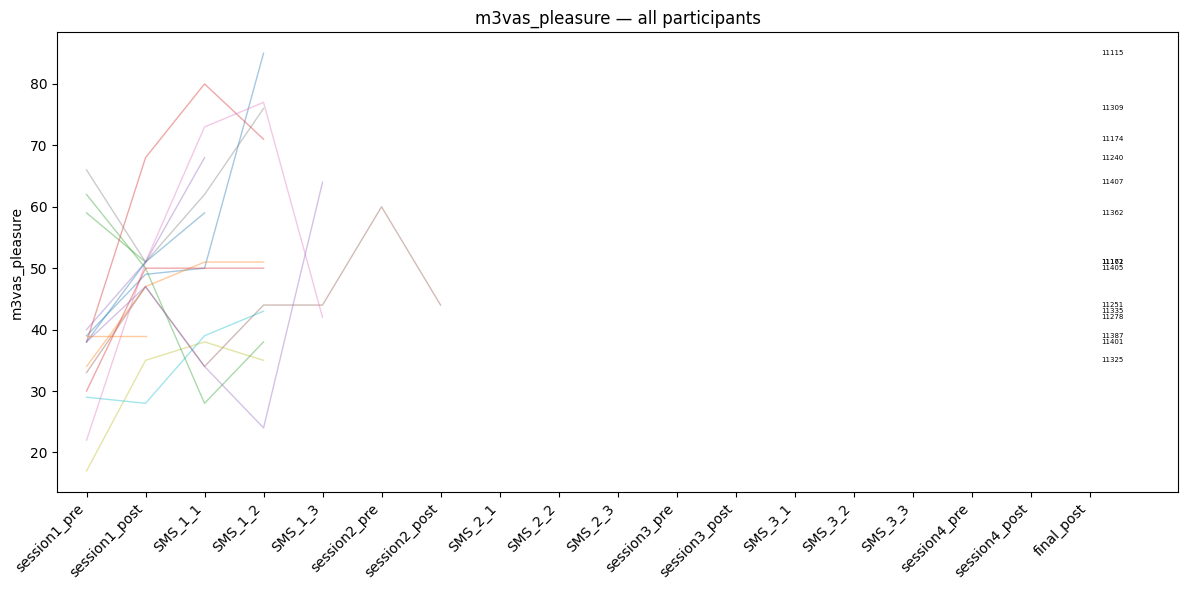

Worsened trajectories (blinded):


,part_id,timepoint,m3vas_pleasure
0,11171,session1_pre,59.0
1,11171,session1_post,51.0
2,11401,session1_pre,62.0
3,11401,session1_post,50.0
4,11401,SMS_1_1,28.0
5,11401,SMS_1_2,38.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_pleasure
0,11401,session1_pre,62.0
1,11401,session1_post,50.0
2,11401,SMS_1_1,28.0
3,11401,SMS_1_2,38.0


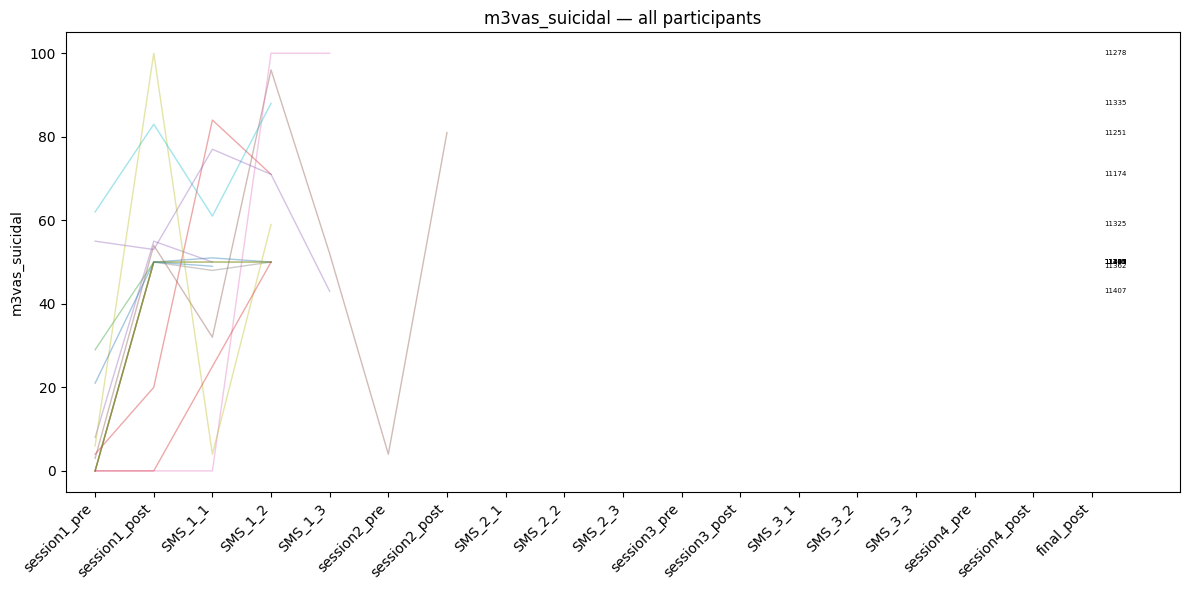

Worsened trajectories (blinded):


,part_id,timepoint,m3vas_suicidal
0,11407,session1_pre,55.0
1,11407,session1_post,53.0
2,11407,SMS_1_1,77.0
3,11407,SMS_1_2,71.0
4,11407,SMS_1_3,43.0


Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ 12):


,part_id,timepoint,m3vas_suicidal
0,11407,session1_pre,55.0
1,11407,session1_post,53.0
2,11407,SMS_1_1,77.0
3,11407,SMS_1_2,71.0
4,11407,SMS_1_3,43.0


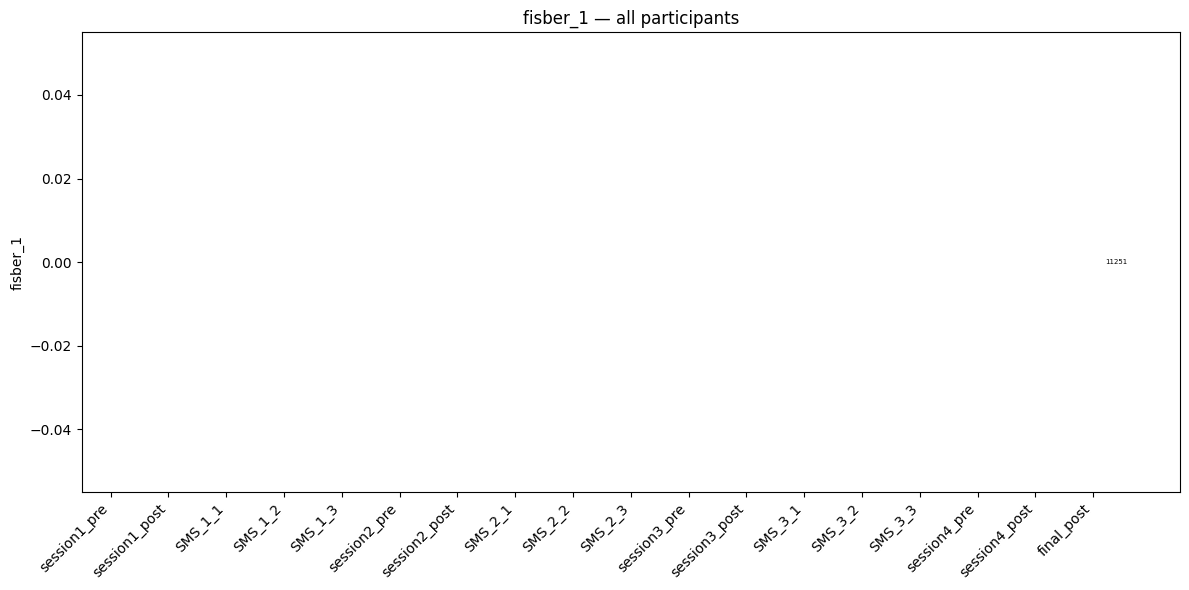

No worsening detected across the sample.


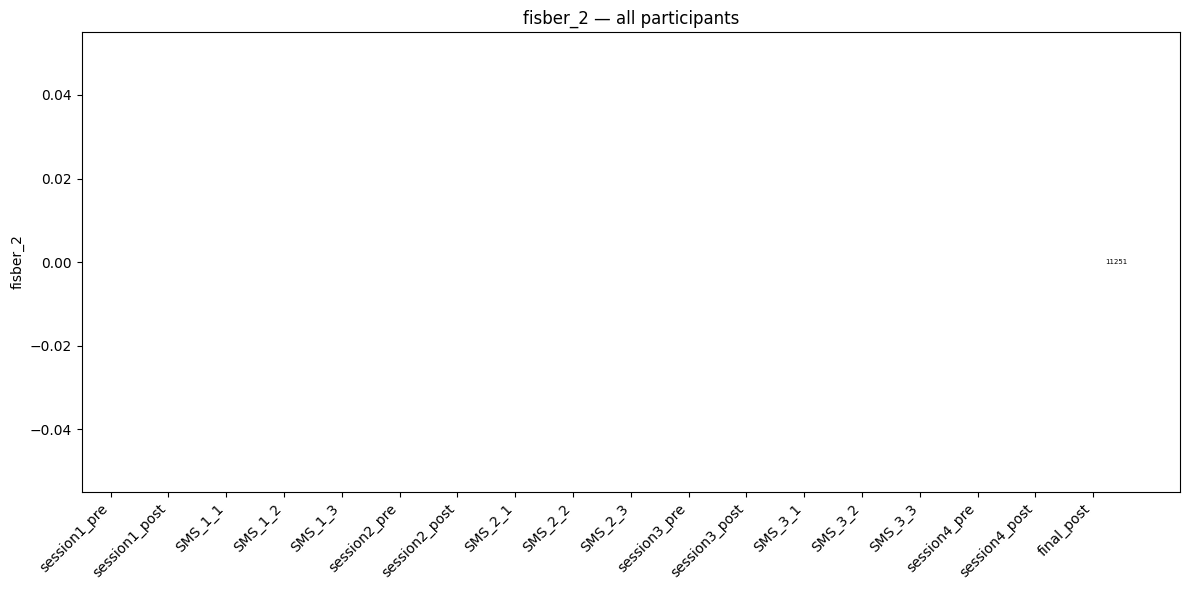

No worsening detected across the sample.


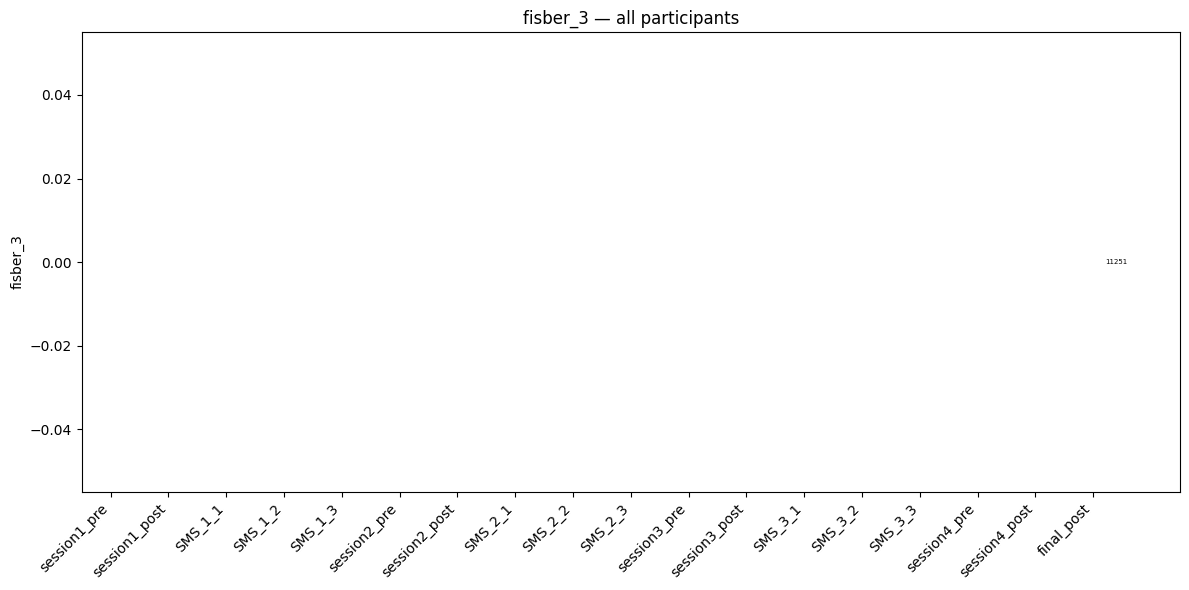

No worsening detected across the sample.


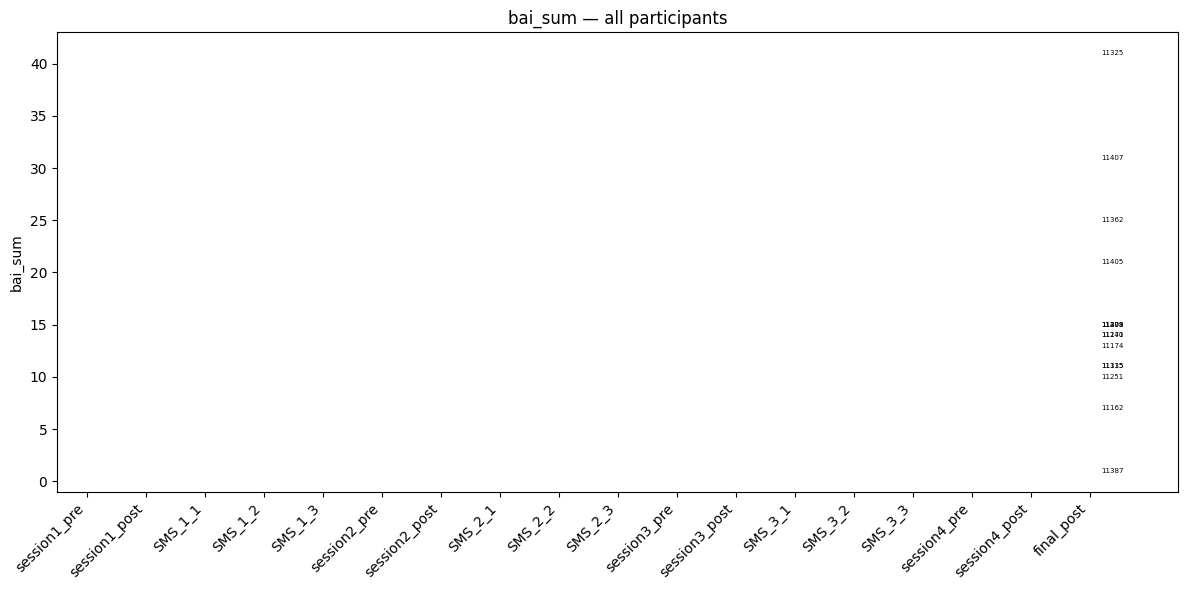

No worsening detected across the sample.


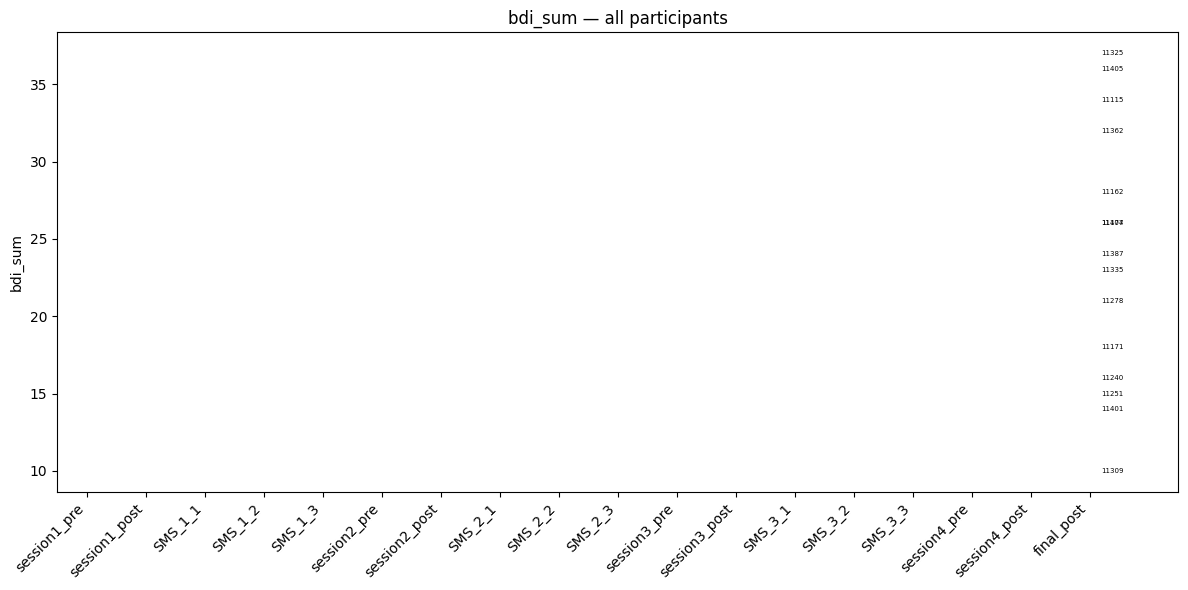

No worsening detected across the sample.


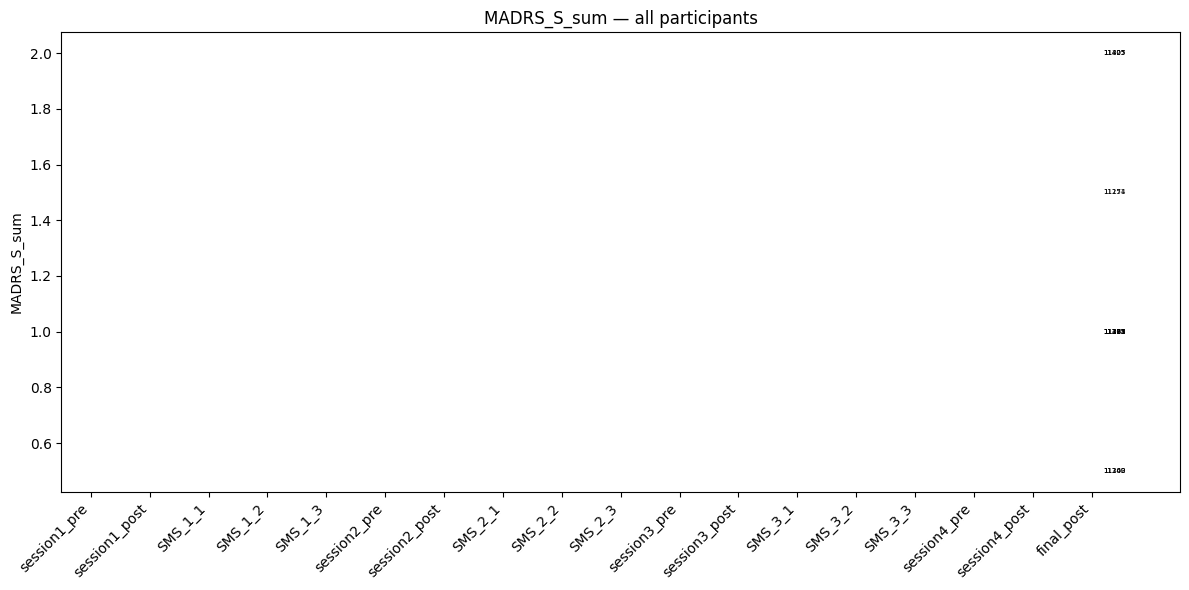

No worsening detected across the sample.


In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum','spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
}
bad_if_lower = {'spane_p','m3vas_mood','m3vas_suicidal','m3vas_pleasure'}

#####
# DEFINE MCID THRESHOLDS
#####
mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS TO CENTER AT ZERO (50 = no change)
#####
def standardize_m3vas(df):
    for var in ('mood', 'pleasure', 'suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            # change-based scales originally from -50 to +50 as ch + 50; subtract 50 to center
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce')
        elif raw_cols:
            # raw VAS 0–100; subtract 50 to center at zero
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce') - 50
        # center change cols as well
        if f"m3vas_{var}" in df.columns and var in ['mood', 'suicidal']:
            df[f"m3vas_{var}"] = df[f"m3vas_{var}"] - 50 if ch_cols else df[f"m3vas_{var}"]
    # invert pleasure so higher = worse, then center
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = (100 - df['m3vas_pleasure']) - 50
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

# Apply standardization
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_trajectories_and_flag(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # Plot trajectories
    fig, ax = plt.subplots(figsize=(12,6))
    x_final = len(ordered_timepoints) - 1
    for pid, grp in df_long.groupby('part_id'):
        s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
        if s.empty: continue
        x = s['timepoint'].cat.codes
        y = s[measure].astype(float)
        ax.plot(x, y, linewidth=1, alpha=0.4)
        ax.text(x_final+0.2, y.iloc[-1], pid, fontsize=5, va='center')
    ax.set_xlim(-0.5, x_final+1.5)
    ax.set_xticks(range(len(ordered_timepoints)))
    ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — all participants")
    plt.tight_layout(); plt.show()

    # Flag worsening
    worsened = []
    for pid, grp in df_long.groupby('part_id'):
        seq = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')[measure].astype(float)
        if len(seq) < 2: continue
        if (measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or \
           (measure in bad_if_lower  and seq.iloc[-1] < seq.iloc[0]):
            worsened.append(pid)
    if worsened:
        print("Worsened trajectories (blinded):")
        display(df_long[df_long['part_id'].isin(worsened)][['part_id','timepoint',measure]]
                .dropna(subset=[measure]).sort_values(['part_id','timepoint']).reset_index(drop=True))
    else:
        print("No worsening detected across the sample.")

    # Flag MCID breaches in worsening direction only
    if measure in mcid_thresholds:
        th = mcid_thresholds[measure]
        breached = []
        for pid, grp in df_long.groupby('part_id'):
            seq = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')[measure].astype(float)
            if len(seq) < 2: continue
            change = seq.iloc[-1] - seq.iloc[0]
            if measure in bad_if_higher and change >= th:
                breached.append(pid)
            elif measure in bad_if_lower and change <= -th:
                breached.append(pid)
        if breached:
            print(f"Participants Changing Above the Minimum Clinical Importance Difference (MCID ≥ {th}):")
            display(df_long[df_long['part_id'].isin(breached)][['part_id','timepoint',measure]]
                    .dropna(subset=[measure]).sort_values(['part_id','timepoint']).reset_index(drop=True))
        else:
            print(f"No participants worsened by at least the MCID of {th} for {measure}.")

#####
# RUN FOR ALL MEASURES
#####
for m in measures:
    plot_trajectories_and_flag(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)


Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                            \
timepoint    session1_post session2_post session3_post session4_post   
condition                                                              
intervention           8.0           7.0           9.0           8.0   

                tol_sd_all                                            
timepoint    session1_post session2_post session3_post session4_post  
condition                                                             
intervention           NaN           NaN           NaN           NaN

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero                                            \
timepoint       session1_post session2_post session3_post session4_post   
condition                                                                 
intervention              8.0           7.0           9.0           8.0   

             tol_sd_nonzero                                            \
timepoint     session1_post session2_post session3_post session4_post   
condition                                                               
intervention            0.0           0.0           0.0           0.0   

             n_side_effects                                            
timepoint     session1_post session2_post session3_post session4_post  
condition                                                              
intervention            1.0           1.0           1.0           1.0